# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.32KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

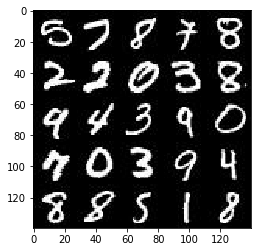

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

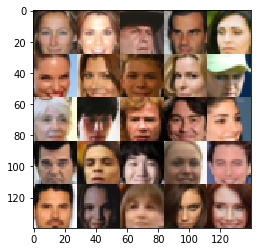

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 5.5727... Generator Loss: 21.7450
Epoch 1/2... Batch 20... Discriminator Loss: 0.9519... Generator Loss: 0.6016
Epoch 1/2... Batch 30... Discriminator Loss: 2.3458... Generator Loss: 0.1335
Epoch 1/2... Batch 40... Discriminator Loss: 1.4043... Generator Loss: 0.4252
Epoch 1/2... Batch 50... Discriminator Loss: 1.0718... Generator Loss: 0.5375
Epoch 1/2... Batch 60... Discriminator Loss: 0.4432... Generator Loss: 4.1253
Epoch 1/2... Batch 70... Discriminator Loss: 0.7468... Generator Loss: 1.0623
Epoch 1/2... Batch 80... Discriminator Loss: 1.5487... Generator Loss: 0.4404
Epoch 1/2... Batch 90... Discriminator Loss: 0.9595... Generator Loss: 1.0639
Epoch 1/2... Batch 100... Discriminator Loss: 1.3216... Generator Loss: 0.5416


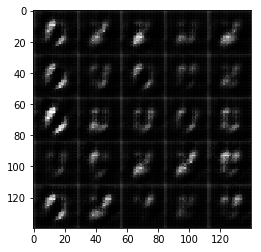

Epoch 1/2... Batch 110... Discriminator Loss: 1.7058... Generator Loss: 0.3198
Epoch 1/2... Batch 120... Discriminator Loss: 1.2341... Generator Loss: 1.3775
Epoch 1/2... Batch 130... Discriminator Loss: 1.4326... Generator Loss: 0.4010
Epoch 1/2... Batch 140... Discriminator Loss: 1.6938... Generator Loss: 2.6445
Epoch 1/2... Batch 150... Discriminator Loss: 1.8669... Generator Loss: 0.2744
Epoch 1/2... Batch 160... Discriminator Loss: 1.7556... Generator Loss: 0.3424
Epoch 1/2... Batch 170... Discriminator Loss: 2.1293... Generator Loss: 0.1903
Epoch 1/2... Batch 180... Discriminator Loss: 1.3618... Generator Loss: 0.5584
Epoch 1/2... Batch 190... Discriminator Loss: 1.3106... Generator Loss: 2.2372
Epoch 1/2... Batch 200... Discriminator Loss: 1.5270... Generator Loss: 2.5235


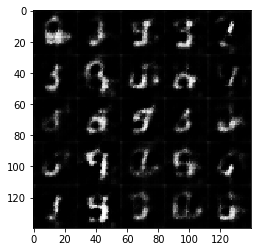

Epoch 1/2... Batch 210... Discriminator Loss: 1.1480... Generator Loss: 1.0312
Epoch 1/2... Batch 220... Discriminator Loss: 1.4896... Generator Loss: 2.0684
Epoch 1/2... Batch 230... Discriminator Loss: 1.0553... Generator Loss: 1.9738
Epoch 1/2... Batch 240... Discriminator Loss: 0.9137... Generator Loss: 0.9217
Epoch 1/2... Batch 250... Discriminator Loss: 1.4646... Generator Loss: 0.5270
Epoch 1/2... Batch 260... Discriminator Loss: 1.6219... Generator Loss: 0.5120
Epoch 1/2... Batch 270... Discriminator Loss: 1.3857... Generator Loss: 0.5121
Epoch 1/2... Batch 280... Discriminator Loss: 1.2964... Generator Loss: 0.6681
Epoch 1/2... Batch 290... Discriminator Loss: 1.2868... Generator Loss: 1.3043
Epoch 1/2... Batch 300... Discriminator Loss: 1.3027... Generator Loss: 1.5174


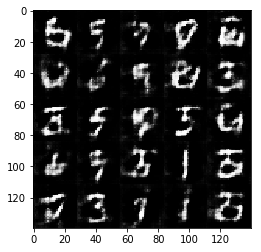

Epoch 1/2... Batch 310... Discriminator Loss: 1.0842... Generator Loss: 0.6291
Epoch 1/2... Batch 320... Discriminator Loss: 1.1397... Generator Loss: 0.6810
Epoch 1/2... Batch 330... Discriminator Loss: 1.5739... Generator Loss: 0.3369
Epoch 1/2... Batch 340... Discriminator Loss: 1.2694... Generator Loss: 0.4851
Epoch 1/2... Batch 350... Discriminator Loss: 1.2849... Generator Loss: 0.6237
Epoch 1/2... Batch 360... Discriminator Loss: 1.7487... Generator Loss: 0.2624
Epoch 1/2... Batch 370... Discriminator Loss: 1.3718... Generator Loss: 0.4235
Epoch 1/2... Batch 380... Discriminator Loss: 1.2416... Generator Loss: 0.7610
Epoch 1/2... Batch 390... Discriminator Loss: 1.1902... Generator Loss: 0.6936
Epoch 1/2... Batch 400... Discriminator Loss: 1.4205... Generator Loss: 0.3893


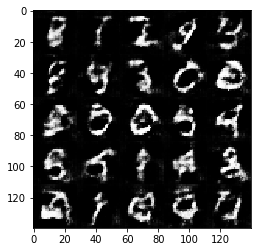

Epoch 1/2... Batch 410... Discriminator Loss: 1.2279... Generator Loss: 0.7749
Epoch 1/2... Batch 420... Discriminator Loss: 1.3471... Generator Loss: 1.8912
Epoch 1/2... Batch 430... Discriminator Loss: 1.3731... Generator Loss: 0.3964
Epoch 1/2... Batch 440... Discriminator Loss: 1.2402... Generator Loss: 0.5500
Epoch 1/2... Batch 450... Discriminator Loss: 1.5487... Generator Loss: 0.3301
Epoch 1/2... Batch 460... Discriminator Loss: 1.1802... Generator Loss: 0.5360
Epoch 1/2... Batch 470... Discriminator Loss: 1.5695... Generator Loss: 0.3034
Epoch 1/2... Batch 480... Discriminator Loss: 1.4296... Generator Loss: 0.3860
Epoch 1/2... Batch 490... Discriminator Loss: 1.2322... Generator Loss: 0.6384
Epoch 1/2... Batch 500... Discriminator Loss: 1.1280... Generator Loss: 1.2422


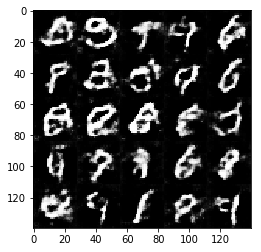

Epoch 1/2... Batch 510... Discriminator Loss: 1.2965... Generator Loss: 1.5696
Epoch 1/2... Batch 520... Discriminator Loss: 1.3095... Generator Loss: 0.4835
Epoch 1/2... Batch 530... Discriminator Loss: 1.4108... Generator Loss: 0.4097
Epoch 1/2... Batch 540... Discriminator Loss: 1.4362... Generator Loss: 0.4254
Epoch 1/2... Batch 550... Discriminator Loss: 1.2586... Generator Loss: 0.7431
Epoch 1/2... Batch 560... Discriminator Loss: 1.3336... Generator Loss: 1.8101
Epoch 1/2... Batch 570... Discriminator Loss: 1.4044... Generator Loss: 1.3472
Epoch 1/2... Batch 580... Discriminator Loss: 1.2879... Generator Loss: 1.3577
Epoch 1/2... Batch 590... Discriminator Loss: 1.2640... Generator Loss: 1.2195
Epoch 1/2... Batch 600... Discriminator Loss: 1.1974... Generator Loss: 0.5371


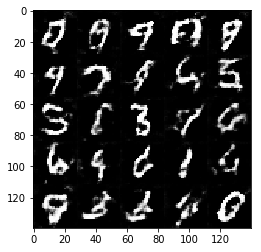

Epoch 1/2... Batch 610... Discriminator Loss: 0.9397... Generator Loss: 0.9737
Epoch 1/2... Batch 620... Discriminator Loss: 1.2627... Generator Loss: 1.3183
Epoch 1/2... Batch 630... Discriminator Loss: 1.2635... Generator Loss: 1.4079
Epoch 1/2... Batch 640... Discriminator Loss: 1.4370... Generator Loss: 1.3775
Epoch 1/2... Batch 650... Discriminator Loss: 1.3223... Generator Loss: 1.6581
Epoch 1/2... Batch 660... Discriminator Loss: 1.0701... Generator Loss: 1.3048
Epoch 1/2... Batch 670... Discriminator Loss: 1.1935... Generator Loss: 1.4195
Epoch 1/2... Batch 680... Discriminator Loss: 1.3942... Generator Loss: 0.4670
Epoch 1/2... Batch 690... Discriminator Loss: 1.4629... Generator Loss: 0.3557
Epoch 1/2... Batch 700... Discriminator Loss: 1.6158... Generator Loss: 0.2644


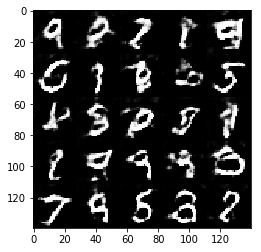

Epoch 1/2... Batch 710... Discriminator Loss: 1.3093... Generator Loss: 0.4493
Epoch 1/2... Batch 720... Discriminator Loss: 1.4548... Generator Loss: 0.3862
Epoch 1/2... Batch 730... Discriminator Loss: 1.4515... Generator Loss: 0.3587
Epoch 1/2... Batch 740... Discriminator Loss: 1.2181... Generator Loss: 1.3912
Epoch 1/2... Batch 750... Discriminator Loss: 1.3854... Generator Loss: 1.4216
Epoch 1/2... Batch 760... Discriminator Loss: 1.2143... Generator Loss: 1.0419
Epoch 1/2... Batch 770... Discriminator Loss: 1.0533... Generator Loss: 1.3012
Epoch 1/2... Batch 780... Discriminator Loss: 1.2754... Generator Loss: 0.4545
Epoch 1/2... Batch 790... Discriminator Loss: 1.0878... Generator Loss: 0.5851
Epoch 1/2... Batch 800... Discriminator Loss: 1.0165... Generator Loss: 0.5974


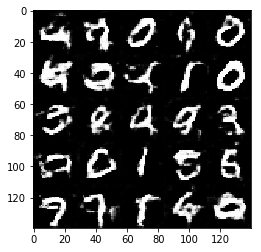

Epoch 1/2... Batch 810... Discriminator Loss: 1.5256... Generator Loss: 2.2162
Epoch 1/2... Batch 820... Discriminator Loss: 1.6396... Generator Loss: 2.2560
Epoch 1/2... Batch 830... Discriminator Loss: 1.1047... Generator Loss: 1.1804
Epoch 1/2... Batch 840... Discriminator Loss: 1.1918... Generator Loss: 0.5227
Epoch 1/2... Batch 850... Discriminator Loss: 1.3357... Generator Loss: 1.2428
Epoch 1/2... Batch 860... Discriminator Loss: 0.9904... Generator Loss: 1.3265
Epoch 1/2... Batch 870... Discriminator Loss: 1.3899... Generator Loss: 0.4093
Epoch 1/2... Batch 880... Discriminator Loss: 1.5227... Generator Loss: 0.3227
Epoch 1/2... Batch 890... Discriminator Loss: 0.9646... Generator Loss: 0.8964
Epoch 1/2... Batch 900... Discriminator Loss: 0.9931... Generator Loss: 1.0460


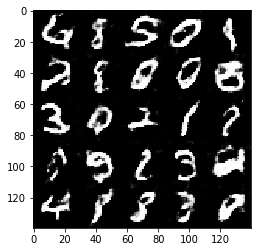

Epoch 1/2... Batch 910... Discriminator Loss: 1.0452... Generator Loss: 0.5682
Epoch 1/2... Batch 920... Discriminator Loss: 2.6991... Generator Loss: 2.2872
Epoch 1/2... Batch 930... Discriminator Loss: 1.3767... Generator Loss: 0.4042
Epoch 1/2... Batch 940... Discriminator Loss: 1.5336... Generator Loss: 0.3116
Epoch 1/2... Batch 950... Discriminator Loss: 1.8381... Generator Loss: 0.2226
Epoch 1/2... Batch 960... Discriminator Loss: 0.9511... Generator Loss: 0.8262
Epoch 1/2... Batch 970... Discriminator Loss: 2.1934... Generator Loss: 0.1490
Epoch 1/2... Batch 980... Discriminator Loss: 1.2072... Generator Loss: 0.8951
Epoch 1/2... Batch 990... Discriminator Loss: 1.4101... Generator Loss: 0.4248
Epoch 1/2... Batch 1000... Discriminator Loss: 1.0429... Generator Loss: 0.6518


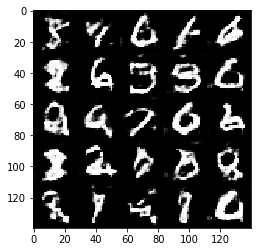

Epoch 1/2... Batch 1010... Discriminator Loss: 1.5543... Generator Loss: 0.3806
Epoch 1/2... Batch 1020... Discriminator Loss: 1.5731... Generator Loss: 0.3008
Epoch 1/2... Batch 1030... Discriminator Loss: 1.5186... Generator Loss: 0.2999
Epoch 1/2... Batch 1040... Discriminator Loss: 1.7847... Generator Loss: 0.2177
Epoch 1/2... Batch 1050... Discriminator Loss: 0.9184... Generator Loss: 1.1144
Epoch 1/2... Batch 1060... Discriminator Loss: 0.9043... Generator Loss: 0.9136
Epoch 1/2... Batch 1070... Discriminator Loss: 1.5558... Generator Loss: 0.3436
Epoch 1/2... Batch 1080... Discriminator Loss: 1.7286... Generator Loss: 0.2302
Epoch 1/2... Batch 1090... Discriminator Loss: 1.1406... Generator Loss: 0.5654
Epoch 1/2... Batch 1100... Discriminator Loss: 1.4352... Generator Loss: 2.1101


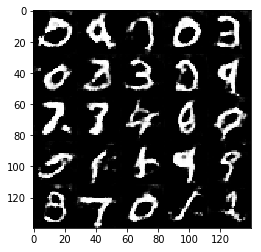

Epoch 1/2... Batch 1110... Discriminator Loss: 1.0186... Generator Loss: 1.1969
Epoch 1/2... Batch 1120... Discriminator Loss: 1.1659... Generator Loss: 0.5145
Epoch 1/2... Batch 1130... Discriminator Loss: 1.7379... Generator Loss: 2.7553
Epoch 1/2... Batch 1140... Discriminator Loss: 0.7787... Generator Loss: 0.9128
Epoch 1/2... Batch 1150... Discriminator Loss: 1.1907... Generator Loss: 1.0976
Epoch 1/2... Batch 1160... Discriminator Loss: 0.7292... Generator Loss: 1.5725
Epoch 1/2... Batch 1170... Discriminator Loss: 1.1829... Generator Loss: 0.4876
Epoch 1/2... Batch 1180... Discriminator Loss: 0.7219... Generator Loss: 0.9767
Epoch 1/2... Batch 1190... Discriminator Loss: 1.0198... Generator Loss: 1.0843
Epoch 1/2... Batch 1200... Discriminator Loss: 0.9223... Generator Loss: 0.9270


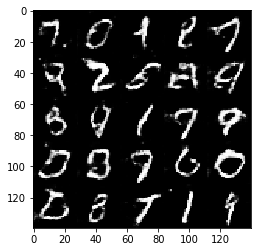

Epoch 1/2... Batch 1210... Discriminator Loss: 1.8425... Generator Loss: 0.2089
Epoch 1/2... Batch 1220... Discriminator Loss: 0.7646... Generator Loss: 1.2258
Epoch 1/2... Batch 1230... Discriminator Loss: 0.6937... Generator Loss: 1.0382
Epoch 1/2... Batch 1240... Discriminator Loss: 1.2086... Generator Loss: 1.9758
Epoch 1/2... Batch 1250... Discriminator Loss: 1.2023... Generator Loss: 0.5047
Epoch 1/2... Batch 1260... Discriminator Loss: 1.0981... Generator Loss: 0.6471
Epoch 1/2... Batch 1270... Discriminator Loss: 0.8117... Generator Loss: 0.7678
Epoch 1/2... Batch 1280... Discriminator Loss: 1.4631... Generator Loss: 3.3140
Epoch 1/2... Batch 1290... Discriminator Loss: 1.6110... Generator Loss: 0.3034
Epoch 1/2... Batch 1300... Discriminator Loss: 0.5887... Generator Loss: 1.0406


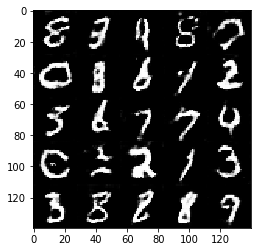

Epoch 1/2... Batch 1310... Discriminator Loss: 0.9543... Generator Loss: 1.3712
Epoch 1/2... Batch 1320... Discriminator Loss: 0.8663... Generator Loss: 1.5163
Epoch 1/2... Batch 1330... Discriminator Loss: 0.9327... Generator Loss: 0.6960
Epoch 1/2... Batch 1340... Discriminator Loss: 1.2320... Generator Loss: 0.4881
Epoch 1/2... Batch 1350... Discriminator Loss: 1.0912... Generator Loss: 1.3479
Epoch 1/2... Batch 1360... Discriminator Loss: 0.6341... Generator Loss: 1.3612
Epoch 1/2... Batch 1370... Discriminator Loss: 0.8814... Generator Loss: 1.9403
Epoch 1/2... Batch 1380... Discriminator Loss: 0.7140... Generator Loss: 1.5775
Epoch 1/2... Batch 1390... Discriminator Loss: 1.3057... Generator Loss: 0.4257
Epoch 1/2... Batch 1400... Discriminator Loss: 0.7441... Generator Loss: 0.8877


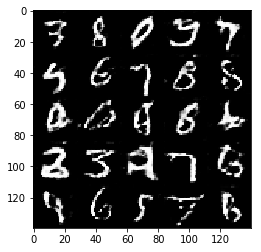

Epoch 1/2... Batch 1410... Discriminator Loss: 1.4316... Generator Loss: 0.4004
Epoch 1/2... Batch 1420... Discriminator Loss: 2.7242... Generator Loss: 0.1335
Epoch 1/2... Batch 1430... Discriminator Loss: 0.9413... Generator Loss: 1.1352
Epoch 1/2... Batch 1440... Discriminator Loss: 0.6383... Generator Loss: 1.3810
Epoch 1/2... Batch 1450... Discriminator Loss: 1.0678... Generator Loss: 0.6766
Epoch 1/2... Batch 1460... Discriminator Loss: 1.5666... Generator Loss: 0.3884
Epoch 1/2... Batch 1470... Discriminator Loss: 1.8643... Generator Loss: 0.2462
Epoch 1/2... Batch 1480... Discriminator Loss: 1.4922... Generator Loss: 0.3629
Epoch 1/2... Batch 1490... Discriminator Loss: 1.1061... Generator Loss: 0.5489
Epoch 1/2... Batch 1500... Discriminator Loss: 0.9832... Generator Loss: 0.6972


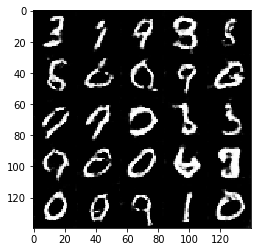

Epoch 1/2... Batch 1510... Discriminator Loss: 0.5556... Generator Loss: 1.9294
Epoch 1/2... Batch 1520... Discriminator Loss: 2.4313... Generator Loss: 0.1588
Epoch 1/2... Batch 1530... Discriminator Loss: 1.0610... Generator Loss: 2.1012
Epoch 1/2... Batch 1540... Discriminator Loss: 0.8852... Generator Loss: 2.4879
Epoch 1/2... Batch 1550... Discriminator Loss: 1.4570... Generator Loss: 0.3938
Epoch 1/2... Batch 1560... Discriminator Loss: 0.8995... Generator Loss: 2.2955
Epoch 1/2... Batch 1570... Discriminator Loss: 0.7595... Generator Loss: 2.2316
Epoch 1/2... Batch 1580... Discriminator Loss: 0.7819... Generator Loss: 0.8624
Epoch 1/2... Batch 1590... Discriminator Loss: 0.8581... Generator Loss: 2.8975
Epoch 1/2... Batch 1600... Discriminator Loss: 1.6473... Generator Loss: 0.3003


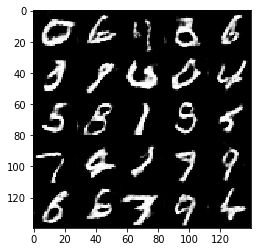

Epoch 1/2... Batch 1610... Discriminator Loss: 0.9180... Generator Loss: 0.7048
Epoch 1/2... Batch 1620... Discriminator Loss: 1.3628... Generator Loss: 0.3953
Epoch 1/2... Batch 1630... Discriminator Loss: 1.1653... Generator Loss: 0.5356
Epoch 1/2... Batch 1640... Discriminator Loss: 1.1801... Generator Loss: 2.1308
Epoch 1/2... Batch 1650... Discriminator Loss: 0.6254... Generator Loss: 1.0820
Epoch 1/2... Batch 1660... Discriminator Loss: 0.5342... Generator Loss: 1.4689
Epoch 1/2... Batch 1670... Discriminator Loss: 1.5508... Generator Loss: 0.3357
Epoch 1/2... Batch 1680... Discriminator Loss: 1.3518... Generator Loss: 0.4015
Epoch 1/2... Batch 1690... Discriminator Loss: 0.4596... Generator Loss: 1.8675
Epoch 1/2... Batch 1700... Discriminator Loss: 1.0972... Generator Loss: 0.5473


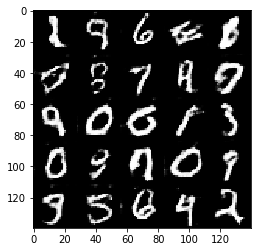

Epoch 1/2... Batch 1710... Discriminator Loss: 0.5504... Generator Loss: 1.2050
Epoch 1/2... Batch 1720... Discriminator Loss: 0.4169... Generator Loss: 1.7933
Epoch 1/2... Batch 1730... Discriminator Loss: 1.8025... Generator Loss: 0.2668
Epoch 1/2... Batch 1740... Discriminator Loss: 0.9503... Generator Loss: 0.6952
Epoch 1/2... Batch 1750... Discriminator Loss: 0.7958... Generator Loss: 1.2538
Epoch 1/2... Batch 1760... Discriminator Loss: 1.4682... Generator Loss: 3.0521
Epoch 1/2... Batch 1770... Discriminator Loss: 1.1756... Generator Loss: 0.5160
Epoch 1/2... Batch 1780... Discriminator Loss: 1.0268... Generator Loss: 1.7236
Epoch 1/2... Batch 1790... Discriminator Loss: 0.9227... Generator Loss: 0.8816
Epoch 1/2... Batch 1800... Discriminator Loss: 1.1233... Generator Loss: 0.6081


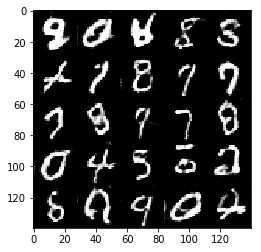

Epoch 1/2... Batch 1810... Discriminator Loss: 0.9343... Generator Loss: 0.8301
Epoch 1/2... Batch 1820... Discriminator Loss: 0.7647... Generator Loss: 1.7656
Epoch 1/2... Batch 1830... Discriminator Loss: 1.3930... Generator Loss: 2.8168
Epoch 1/2... Batch 1840... Discriminator Loss: 1.6194... Generator Loss: 0.3149
Epoch 1/2... Batch 1850... Discriminator Loss: 1.5215... Generator Loss: 3.4824
Epoch 1/2... Batch 1860... Discriminator Loss: 0.8487... Generator Loss: 1.1567
Epoch 1/2... Batch 1870... Discriminator Loss: 0.6838... Generator Loss: 1.2396
Epoch 2/2... Batch 10... Discriminator Loss: 0.8301... Generator Loss: 0.8272
Epoch 2/2... Batch 20... Discriminator Loss: 0.3838... Generator Loss: 2.1476
Epoch 2/2... Batch 30... Discriminator Loss: 1.7832... Generator Loss: 3.6318
Epoch 2/2... Batch 40... Discriminator Loss: 0.9550... Generator Loss: 0.7372
Epoch 2/2... Batch 50... Discriminator Loss: 0.7282... Generator Loss: 1.5875
Epoch 2/2... Batch 60... Discriminator Loss: 1.197

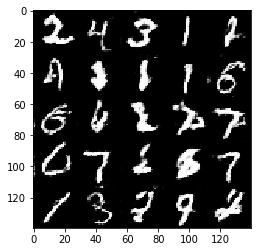

Epoch 2/2... Batch 110... Discriminator Loss: 1.4609... Generator Loss: 0.3715
Epoch 2/2... Batch 120... Discriminator Loss: 0.5053... Generator Loss: 1.3580
Epoch 2/2... Batch 130... Discriminator Loss: 1.2567... Generator Loss: 3.2323
Epoch 2/2... Batch 140... Discriminator Loss: 0.8172... Generator Loss: 0.8716
Epoch 2/2... Batch 150... Discriminator Loss: 1.6560... Generator Loss: 0.3417
Epoch 2/2... Batch 160... Discriminator Loss: 0.9742... Generator Loss: 0.7957
Epoch 2/2... Batch 170... Discriminator Loss: 0.5168... Generator Loss: 1.1698
Epoch 2/2... Batch 180... Discriminator Loss: 0.2194... Generator Loss: 2.3979
Epoch 2/2... Batch 190... Discriminator Loss: 2.3053... Generator Loss: 0.2999
Epoch 2/2... Batch 200... Discriminator Loss: 0.8011... Generator Loss: 2.6162


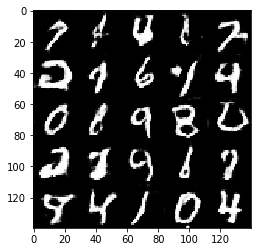

Epoch 2/2... Batch 210... Discriminator Loss: 0.7879... Generator Loss: 1.9255
Epoch 2/2... Batch 220... Discriminator Loss: 0.5515... Generator Loss: 1.2590
Epoch 2/2... Batch 230... Discriminator Loss: 1.8310... Generator Loss: 0.2734
Epoch 2/2... Batch 240... Discriminator Loss: 0.4863... Generator Loss: 1.2807
Epoch 2/2... Batch 250... Discriminator Loss: 0.4528... Generator Loss: 1.4840
Epoch 2/2... Batch 260... Discriminator Loss: 0.3165... Generator Loss: 1.9677
Epoch 2/2... Batch 270... Discriminator Loss: 0.3008... Generator Loss: 1.9200
Epoch 2/2... Batch 280... Discriminator Loss: 0.3201... Generator Loss: 1.7527
Epoch 2/2... Batch 290... Discriminator Loss: 0.7463... Generator Loss: 1.7285
Epoch 2/2... Batch 300... Discriminator Loss: 0.7045... Generator Loss: 1.1459


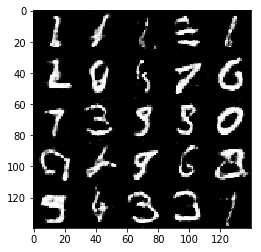

Epoch 2/2... Batch 310... Discriminator Loss: 1.0408... Generator Loss: 0.5584
Epoch 2/2... Batch 320... Discriminator Loss: 1.1598... Generator Loss: 2.9523
Epoch 2/2... Batch 330... Discriminator Loss: 1.5402... Generator Loss: 3.2699
Epoch 2/2... Batch 340... Discriminator Loss: 1.2180... Generator Loss: 0.4889
Epoch 2/2... Batch 350... Discriminator Loss: 2.5220... Generator Loss: 0.1571
Epoch 2/2... Batch 360... Discriminator Loss: 0.9510... Generator Loss: 2.3001
Epoch 2/2... Batch 370... Discriminator Loss: 1.1305... Generator Loss: 0.5116
Epoch 2/2... Batch 380... Discriminator Loss: 0.9283... Generator Loss: 0.6113
Epoch 2/2... Batch 390... Discriminator Loss: 0.7482... Generator Loss: 1.0609
Epoch 2/2... Batch 400... Discriminator Loss: 2.4183... Generator Loss: 0.1557


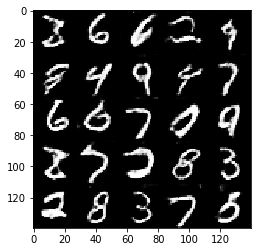

Epoch 2/2... Batch 410... Discriminator Loss: 0.5963... Generator Loss: 1.1894
Epoch 2/2... Batch 420... Discriminator Loss: 0.6151... Generator Loss: 3.1212
Epoch 2/2... Batch 430... Discriminator Loss: 1.7798... Generator Loss: 0.3060
Epoch 2/2... Batch 440... Discriminator Loss: 0.7246... Generator Loss: 2.4384
Epoch 2/2... Batch 450... Discriminator Loss: 0.5135... Generator Loss: 1.4936
Epoch 2/2... Batch 460... Discriminator Loss: 0.6685... Generator Loss: 1.0317
Epoch 2/2... Batch 470... Discriminator Loss: 1.1869... Generator Loss: 0.5001
Epoch 2/2... Batch 480... Discriminator Loss: 1.2788... Generator Loss: 0.5012
Epoch 2/2... Batch 490... Discriminator Loss: 0.2588... Generator Loss: 2.6695
Epoch 2/2... Batch 500... Discriminator Loss: 0.2309... Generator Loss: 1.9624


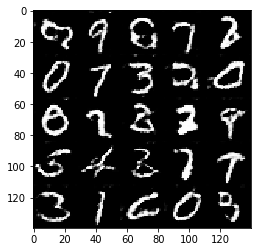

Epoch 2/2... Batch 510... Discriminator Loss: 0.3048... Generator Loss: 2.0746
Epoch 2/2... Batch 520... Discriminator Loss: 1.0712... Generator Loss: 3.0881
Epoch 2/2... Batch 530... Discriminator Loss: 1.2197... Generator Loss: 0.5293
Epoch 2/2... Batch 540... Discriminator Loss: 1.3230... Generator Loss: 0.4609
Epoch 2/2... Batch 550... Discriminator Loss: 0.9606... Generator Loss: 0.6866
Epoch 2/2... Batch 560... Discriminator Loss: 0.5449... Generator Loss: 2.7000
Epoch 2/2... Batch 570... Discriminator Loss: 1.1406... Generator Loss: 0.6078
Epoch 2/2... Batch 580... Discriminator Loss: 0.5458... Generator Loss: 2.6543
Epoch 2/2... Batch 590... Discriminator Loss: 0.3274... Generator Loss: 1.7935
Epoch 2/2... Batch 600... Discriminator Loss: 0.2810... Generator Loss: 2.0508


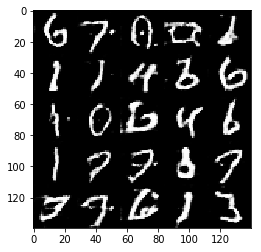

Epoch 2/2... Batch 610... Discriminator Loss: 0.3313... Generator Loss: 1.7788
Epoch 2/2... Batch 620... Discriminator Loss: 3.0730... Generator Loss: 0.0732
Epoch 2/2... Batch 630... Discriminator Loss: 0.7390... Generator Loss: 2.4776
Epoch 2/2... Batch 640... Discriminator Loss: 0.5286... Generator Loss: 2.8824
Epoch 2/2... Batch 650... Discriminator Loss: 0.4060... Generator Loss: 2.4807
Epoch 2/2... Batch 660... Discriminator Loss: 0.2899... Generator Loss: 3.1371
Epoch 2/2... Batch 670... Discriminator Loss: 0.8744... Generator Loss: 0.7727
Epoch 2/2... Batch 680... Discriminator Loss: 1.0675... Generator Loss: 0.6525
Epoch 2/2... Batch 690... Discriminator Loss: 0.5467... Generator Loss: 1.3649
Epoch 2/2... Batch 700... Discriminator Loss: 1.9365... Generator Loss: 4.6104


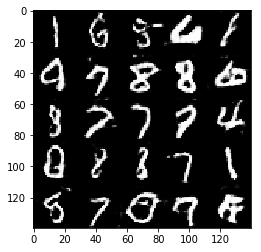

Epoch 2/2... Batch 710... Discriminator Loss: 1.2952... Generator Loss: 2.6006
Epoch 2/2... Batch 720... Discriminator Loss: 1.5537... Generator Loss: 0.3579
Epoch 2/2... Batch 730... Discriminator Loss: 0.6357... Generator Loss: 1.6259
Epoch 2/2... Batch 740... Discriminator Loss: 0.4115... Generator Loss: 1.7666
Epoch 2/2... Batch 750... Discriminator Loss: 0.6242... Generator Loss: 1.0897
Epoch 2/2... Batch 760... Discriminator Loss: 0.9957... Generator Loss: 3.6629
Epoch 2/2... Batch 770... Discriminator Loss: 0.4710... Generator Loss: 2.8775
Epoch 2/2... Batch 780... Discriminator Loss: 0.5592... Generator Loss: 1.2376
Epoch 2/2... Batch 790... Discriminator Loss: 0.3897... Generator Loss: 1.6010
Epoch 2/2... Batch 800... Discriminator Loss: 0.2594... Generator Loss: 2.5342


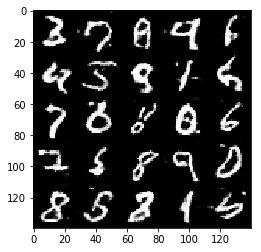

Epoch 2/2... Batch 810... Discriminator Loss: 1.1857... Generator Loss: 0.8221
Epoch 2/2... Batch 820... Discriminator Loss: 2.2547... Generator Loss: 0.1565
Epoch 2/2... Batch 830... Discriminator Loss: 1.7488... Generator Loss: 0.2456
Epoch 2/2... Batch 840... Discriminator Loss: 0.6331... Generator Loss: 1.0919
Epoch 2/2... Batch 850... Discriminator Loss: 0.5455... Generator Loss: 1.2057
Epoch 2/2... Batch 860... Discriminator Loss: 0.5271... Generator Loss: 1.2615
Epoch 2/2... Batch 870... Discriminator Loss: 0.3139... Generator Loss: 2.2721
Epoch 2/2... Batch 880... Discriminator Loss: 1.0822... Generator Loss: 0.6540
Epoch 2/2... Batch 890... Discriminator Loss: 0.6359... Generator Loss: 1.2218
Epoch 2/2... Batch 900... Discriminator Loss: 1.8176... Generator Loss: 5.1146


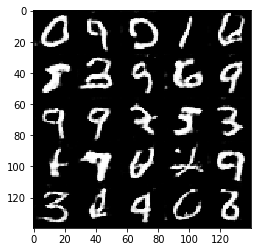

Epoch 2/2... Batch 910... Discriminator Loss: 1.0335... Generator Loss: 0.7254
Epoch 2/2... Batch 920... Discriminator Loss: 1.7528... Generator Loss: 0.3121
Epoch 2/2... Batch 930... Discriminator Loss: 0.6313... Generator Loss: 1.1043
Epoch 2/2... Batch 940... Discriminator Loss: 0.5384... Generator Loss: 1.1177
Epoch 2/2... Batch 950... Discriminator Loss: 0.9294... Generator Loss: 0.7124
Epoch 2/2... Batch 960... Discriminator Loss: 0.6626... Generator Loss: 0.9406
Epoch 2/2... Batch 970... Discriminator Loss: 0.6461... Generator Loss: 1.1230
Epoch 2/2... Batch 980... Discriminator Loss: 0.3738... Generator Loss: 2.5695
Epoch 2/2... Batch 990... Discriminator Loss: 0.6138... Generator Loss: 3.6022
Epoch 2/2... Batch 1000... Discriminator Loss: 0.6753... Generator Loss: 1.0953


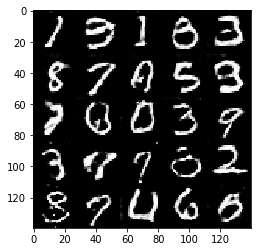

Epoch 2/2... Batch 1010... Discriminator Loss: 0.5322... Generator Loss: 1.1482
Epoch 2/2... Batch 1020... Discriminator Loss: 0.5712... Generator Loss: 3.6823
Epoch 2/2... Batch 1030... Discriminator Loss: 0.8645... Generator Loss: 0.8693
Epoch 2/2... Batch 1040... Discriminator Loss: 1.3820... Generator Loss: 0.4344
Epoch 2/2... Batch 1050... Discriminator Loss: 1.3044... Generator Loss: 0.5315
Epoch 2/2... Batch 1060... Discriminator Loss: 0.4939... Generator Loss: 1.8476
Epoch 2/2... Batch 1070... Discriminator Loss: 0.7905... Generator Loss: 0.9819
Epoch 2/2... Batch 1080... Discriminator Loss: 0.4373... Generator Loss: 1.5778
Epoch 2/2... Batch 1090... Discriminator Loss: 1.8069... Generator Loss: 0.2659
Epoch 2/2... Batch 1100... Discriminator Loss: 0.6140... Generator Loss: 2.1932


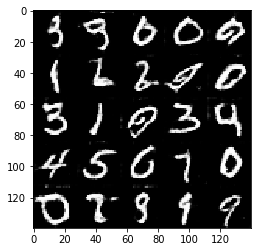

Epoch 2/2... Batch 1110... Discriminator Loss: 2.0794... Generator Loss: 0.2544
Epoch 2/2... Batch 1120... Discriminator Loss: 0.8832... Generator Loss: 0.6603
Epoch 2/2... Batch 1130... Discriminator Loss: 0.3397... Generator Loss: 1.7140
Epoch 2/2... Batch 1140... Discriminator Loss: 0.4155... Generator Loss: 1.5036
Epoch 2/2... Batch 1150... Discriminator Loss: 0.7635... Generator Loss: 0.9832
Epoch 2/2... Batch 1160... Discriminator Loss: 0.4155... Generator Loss: 1.3610
Epoch 2/2... Batch 1170... Discriminator Loss: 2.4140... Generator Loss: 6.1762
Epoch 2/2... Batch 1180... Discriminator Loss: 0.7942... Generator Loss: 0.8818
Epoch 2/2... Batch 1190... Discriminator Loss: 1.0150... Generator Loss: 0.6962
Epoch 2/2... Batch 1200... Discriminator Loss: 0.8574... Generator Loss: 0.7701


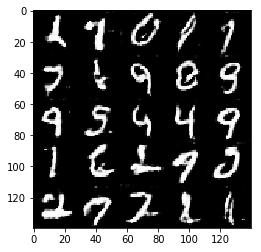

Epoch 2/2... Batch 1210... Discriminator Loss: 2.2027... Generator Loss: 0.2668
Epoch 2/2... Batch 1220... Discriminator Loss: 0.3460... Generator Loss: 1.9150
Epoch 2/2... Batch 1230... Discriminator Loss: 0.5304... Generator Loss: 1.1486
Epoch 2/2... Batch 1240... Discriminator Loss: 0.6583... Generator Loss: 3.6709
Epoch 2/2... Batch 1250... Discriminator Loss: 1.2160... Generator Loss: 0.4888
Epoch 2/2... Batch 1260... Discriminator Loss: 0.4557... Generator Loss: 2.3950
Epoch 2/2... Batch 1270... Discriminator Loss: 0.7598... Generator Loss: 0.8738
Epoch 2/2... Batch 1280... Discriminator Loss: 1.9601... Generator Loss: 4.3490
Epoch 2/2... Batch 1290... Discriminator Loss: 1.3217... Generator Loss: 0.4876
Epoch 2/2... Batch 1300... Discriminator Loss: 0.2745... Generator Loss: 2.3236


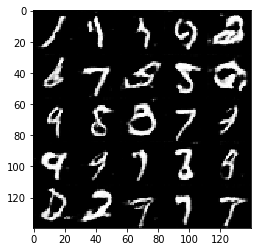

Epoch 2/2... Batch 1310... Discriminator Loss: 0.4760... Generator Loss: 1.5710
Epoch 2/2... Batch 1320... Discriminator Loss: 0.2269... Generator Loss: 2.1059
Epoch 2/2... Batch 1330... Discriminator Loss: 0.7987... Generator Loss: 1.1041
Epoch 2/2... Batch 1340... Discriminator Loss: 2.0748... Generator Loss: 0.2218
Epoch 2/2... Batch 1350... Discriminator Loss: 0.7613... Generator Loss: 0.8770
Epoch 2/2... Batch 1360... Discriminator Loss: 0.8486... Generator Loss: 0.8127
Epoch 2/2... Batch 1370... Discriminator Loss: 0.3413... Generator Loss: 1.7048
Epoch 2/2... Batch 1380... Discriminator Loss: 0.3898... Generator Loss: 2.2127
Epoch 2/2... Batch 1390... Discriminator Loss: 2.8778... Generator Loss: 0.1531
Epoch 2/2... Batch 1400... Discriminator Loss: 0.5413... Generator Loss: 1.2918


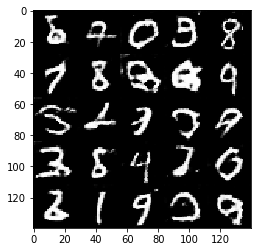

Epoch 2/2... Batch 1410... Discriminator Loss: 0.5619... Generator Loss: 1.2857
Epoch 2/2... Batch 1420... Discriminator Loss: 0.2466... Generator Loss: 1.9482
Epoch 2/2... Batch 1430... Discriminator Loss: 0.9040... Generator Loss: 0.8425
Epoch 2/2... Batch 1440... Discriminator Loss: 0.3832... Generator Loss: 1.8316
Epoch 2/2... Batch 1450... Discriminator Loss: 1.0766... Generator Loss: 0.5600
Epoch 2/2... Batch 1460... Discriminator Loss: 1.1765... Generator Loss: 4.4889
Epoch 2/2... Batch 1470... Discriminator Loss: 0.8023... Generator Loss: 1.2374
Epoch 2/2... Batch 1480... Discriminator Loss: 1.1070... Generator Loss: 0.7727
Epoch 2/2... Batch 1490... Discriminator Loss: 1.0635... Generator Loss: 0.5988
Epoch 2/2... Batch 1500... Discriminator Loss: 0.5682... Generator Loss: 1.2754


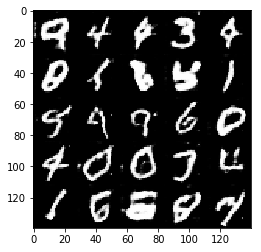

Epoch 2/2... Batch 1510... Discriminator Loss: 0.5958... Generator Loss: 1.1096
Epoch 2/2... Batch 1520... Discriminator Loss: 0.1528... Generator Loss: 2.6303
Epoch 2/2... Batch 1530... Discriminator Loss: 0.2681... Generator Loss: 1.7989
Epoch 2/2... Batch 1540... Discriminator Loss: 0.2919... Generator Loss: 1.9104
Epoch 2/2... Batch 1550... Discriminator Loss: 0.5128... Generator Loss: 1.3500
Epoch 2/2... Batch 1560... Discriminator Loss: 0.4447... Generator Loss: 1.4769
Epoch 2/2... Batch 1570... Discriminator Loss: 0.4379... Generator Loss: 1.5165
Epoch 2/2... Batch 1580... Discriminator Loss: 0.4555... Generator Loss: 1.3840
Epoch 2/2... Batch 1590... Discriminator Loss: 0.5217... Generator Loss: 1.3793
Epoch 2/2... Batch 1600... Discriminator Loss: 2.8415... Generator Loss: 0.2279


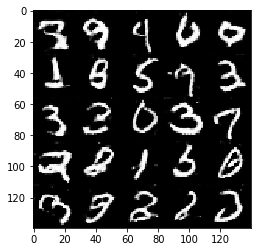

Epoch 2/2... Batch 1610... Discriminator Loss: 0.2780... Generator Loss: 2.6703
Epoch 2/2... Batch 1620... Discriminator Loss: 0.5168... Generator Loss: 1.2065
Epoch 2/2... Batch 1630... Discriminator Loss: 1.3563... Generator Loss: 0.4188
Epoch 2/2... Batch 1640... Discriminator Loss: 0.8994... Generator Loss: 4.1330
Epoch 2/2... Batch 1650... Discriminator Loss: 1.3458... Generator Loss: 0.5200
Epoch 2/2... Batch 1660... Discriminator Loss: 1.2407... Generator Loss: 0.6065
Epoch 2/2... Batch 1670... Discriminator Loss: 0.6298... Generator Loss: 4.4726
Epoch 2/2... Batch 1680... Discriminator Loss: 0.9525... Generator Loss: 0.7725
Epoch 2/2... Batch 1690... Discriminator Loss: 0.6334... Generator Loss: 1.0386
Epoch 2/2... Batch 1700... Discriminator Loss: 0.6830... Generator Loss: 1.1050


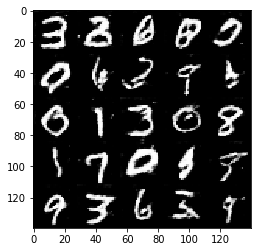

Epoch 2/2... Batch 1710... Discriminator Loss: 1.9989... Generator Loss: 0.2677
Epoch 2/2... Batch 1720... Discriminator Loss: 0.4154... Generator Loss: 1.8254
Epoch 2/2... Batch 1730... Discriminator Loss: 0.6067... Generator Loss: 1.4835
Epoch 2/2... Batch 1740... Discriminator Loss: 0.9314... Generator Loss: 0.7174
Epoch 2/2... Batch 1750... Discriminator Loss: 0.3652... Generator Loss: 2.2369
Epoch 2/2... Batch 1760... Discriminator Loss: 0.7610... Generator Loss: 1.0158
Epoch 2/2... Batch 1770... Discriminator Loss: 0.3616... Generator Loss: 3.1071
Epoch 2/2... Batch 1780... Discriminator Loss: 2.9540... Generator Loss: 0.1462
Epoch 2/2... Batch 1790... Discriminator Loss: 1.8743... Generator Loss: 0.3228
Epoch 2/2... Batch 1800... Discriminator Loss: 0.5043... Generator Loss: 1.4257


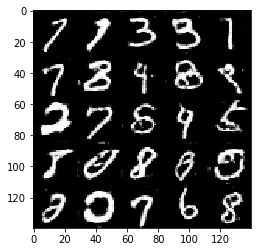

Epoch 2/2... Batch 1810... Discriminator Loss: 0.6485... Generator Loss: 1.0157
Epoch 2/2... Batch 1820... Discriminator Loss: 0.4878... Generator Loss: 3.2695
Epoch 2/2... Batch 1830... Discriminator Loss: 2.4242... Generator Loss: 4.9480
Epoch 2/2... Batch 1840... Discriminator Loss: 0.6481... Generator Loss: 1.1155
Epoch 2/2... Batch 1850... Discriminator Loss: 0.6298... Generator Loss: 1.1006
Epoch 2/2... Batch 1860... Discriminator Loss: 1.7393... Generator Loss: 0.2997
Epoch 2/2... Batch 1870... Discriminator Loss: 0.5472... Generator Loss: 1.2329


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.0643... Generator Loss: 15.1431
Epoch 1/1... Batch 20... Discriminator Loss: 0.2687... Generator Loss: 3.6314
Epoch 1/1... Batch 30... Discriminator Loss: 1.6846... Generator Loss: 6.3087
Epoch 1/1... Batch 40... Discriminator Loss: 1.0453... Generator Loss: 1.4422
Epoch 1/1... Batch 50... Discriminator Loss: 1.4399... Generator Loss: 2.7582
Epoch 1/1... Batch 60... Discriminator Loss: 1.0751... Generator Loss: 1.5113
Epoch 1/1... Batch 70... Discriminator Loss: 1.0570... Generator Loss: 0.7314
Epoch 1/1... Batch 80... Discriminator Loss: 1.5330... Generator Loss: 2.2064
Epoch 1/1... Batch 90... Discriminator Loss: 2.2035... Generator Loss: 3.8397
Epoch 1/1... Batch 100... Discriminator Loss: 1.8180... Generator Loss: 0.5632


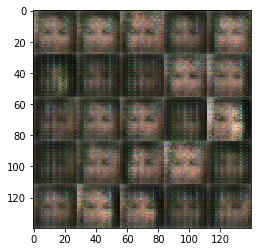

Epoch 1/1... Batch 110... Discriminator Loss: 1.5113... Generator Loss: 0.4657
Epoch 1/1... Batch 120... Discriminator Loss: 1.5169... Generator Loss: 0.9917
Epoch 1/1... Batch 130... Discriminator Loss: 1.6829... Generator Loss: 0.3337
Epoch 1/1... Batch 140... Discriminator Loss: 1.8379... Generator Loss: 0.4975
Epoch 1/1... Batch 150... Discriminator Loss: 1.2961... Generator Loss: 1.7152
Epoch 1/1... Batch 160... Discriminator Loss: 1.5189... Generator Loss: 0.4284
Epoch 1/1... Batch 170... Discriminator Loss: 1.3878... Generator Loss: 0.6757
Epoch 1/1... Batch 180... Discriminator Loss: 1.8225... Generator Loss: 0.2696
Epoch 1/1... Batch 190... Discriminator Loss: 1.0535... Generator Loss: 0.8124
Epoch 1/1... Batch 200... Discriminator Loss: 1.0687... Generator Loss: 0.8391


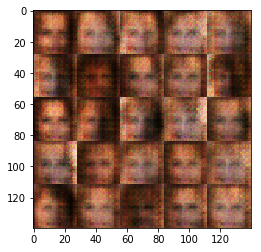

Epoch 1/1... Batch 210... Discriminator Loss: 1.5630... Generator Loss: 0.4768
Epoch 1/1... Batch 220... Discriminator Loss: 1.3404... Generator Loss: 0.5572
Epoch 1/1... Batch 230... Discriminator Loss: 1.2546... Generator Loss: 0.7302
Epoch 1/1... Batch 240... Discriminator Loss: 1.5677... Generator Loss: 0.4018
Epoch 1/1... Batch 250... Discriminator Loss: 1.7293... Generator Loss: 0.5067
Epoch 1/1... Batch 260... Discriminator Loss: 1.2964... Generator Loss: 0.6398
Epoch 1/1... Batch 270... Discriminator Loss: 1.5567... Generator Loss: 0.5880
Epoch 1/1... Batch 280... Discriminator Loss: 1.4379... Generator Loss: 0.3470
Epoch 1/1... Batch 290... Discriminator Loss: 1.8867... Generator Loss: 0.2273
Epoch 1/1... Batch 300... Discriminator Loss: 1.4028... Generator Loss: 0.5938


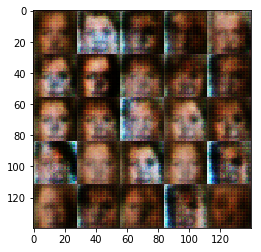

Epoch 1/1... Batch 310... Discriminator Loss: 1.4068... Generator Loss: 0.7579
Epoch 1/1... Batch 320... Discriminator Loss: 1.3797... Generator Loss: 0.5007
Epoch 1/1... Batch 330... Discriminator Loss: 1.1078... Generator Loss: 0.9998
Epoch 1/1... Batch 340... Discriminator Loss: 1.4595... Generator Loss: 1.5808
Epoch 1/1... Batch 350... Discriminator Loss: 1.3865... Generator Loss: 0.5927
Epoch 1/1... Batch 360... Discriminator Loss: 1.3491... Generator Loss: 1.0555
Epoch 1/1... Batch 370... Discriminator Loss: 2.4988... Generator Loss: 2.6569
Epoch 1/1... Batch 380... Discriminator Loss: 1.3943... Generator Loss: 0.9034
Epoch 1/1... Batch 390... Discriminator Loss: 1.4045... Generator Loss: 0.6279
Epoch 1/1... Batch 400... Discriminator Loss: 1.1189... Generator Loss: 0.6293


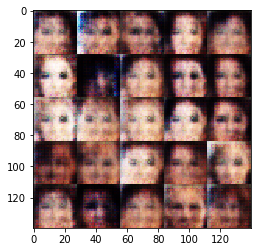

Epoch 1/1... Batch 410... Discriminator Loss: 1.4149... Generator Loss: 0.6736
Epoch 1/1... Batch 420... Discriminator Loss: 1.2874... Generator Loss: 0.4922
Epoch 1/1... Batch 430... Discriminator Loss: 1.3330... Generator Loss: 0.7607
Epoch 1/1... Batch 440... Discriminator Loss: 1.2652... Generator Loss: 0.6645
Epoch 1/1... Batch 450... Discriminator Loss: 2.2174... Generator Loss: 1.9389
Epoch 1/1... Batch 460... Discriminator Loss: 1.3303... Generator Loss: 0.7176
Epoch 1/1... Batch 470... Discriminator Loss: 0.8282... Generator Loss: 1.4587
Epoch 1/1... Batch 480... Discriminator Loss: 1.3185... Generator Loss: 0.6334
Epoch 1/1... Batch 490... Discriminator Loss: 1.0939... Generator Loss: 0.7517
Epoch 1/1... Batch 500... Discriminator Loss: 1.0784... Generator Loss: 0.6647


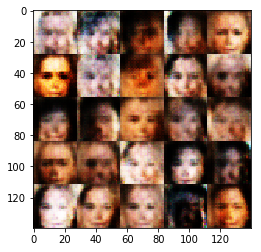

Epoch 1/1... Batch 510... Discriminator Loss: 1.2566... Generator Loss: 0.8524
Epoch 1/1... Batch 520... Discriminator Loss: 1.0530... Generator Loss: 0.8924
Epoch 1/1... Batch 530... Discriminator Loss: 1.4052... Generator Loss: 1.7574
Epoch 1/1... Batch 540... Discriminator Loss: 1.0951... Generator Loss: 0.7489
Epoch 1/1... Batch 550... Discriminator Loss: 1.6005... Generator Loss: 0.5385
Epoch 1/1... Batch 560... Discriminator Loss: 1.5590... Generator Loss: 0.5540
Epoch 1/1... Batch 570... Discriminator Loss: 1.2810... Generator Loss: 0.4889
Epoch 1/1... Batch 580... Discriminator Loss: 1.8848... Generator Loss: 1.6985
Epoch 1/1... Batch 590... Discriminator Loss: 1.7326... Generator Loss: 0.2942
Epoch 1/1... Batch 600... Discriminator Loss: 1.5652... Generator Loss: 0.3384


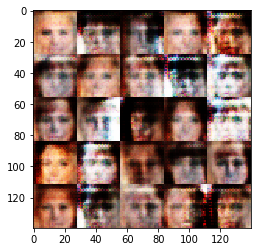

Epoch 1/1... Batch 610... Discriminator Loss: 1.5991... Generator Loss: 0.3186
Epoch 1/1... Batch 620... Discriminator Loss: 1.4038... Generator Loss: 0.7049
Epoch 1/1... Batch 630... Discriminator Loss: 1.3738... Generator Loss: 0.8456
Epoch 1/1... Batch 640... Discriminator Loss: 1.3405... Generator Loss: 0.6705
Epoch 1/1... Batch 650... Discriminator Loss: 1.6250... Generator Loss: 0.4059
Epoch 1/1... Batch 660... Discriminator Loss: 0.9217... Generator Loss: 0.7205
Epoch 1/1... Batch 670... Discriminator Loss: 1.2474... Generator Loss: 0.8542
Epoch 1/1... Batch 680... Discriminator Loss: 1.2526... Generator Loss: 0.5783
Epoch 1/1... Batch 690... Discriminator Loss: 1.5105... Generator Loss: 0.3051
Epoch 1/1... Batch 700... Discriminator Loss: 1.4112... Generator Loss: 0.5583


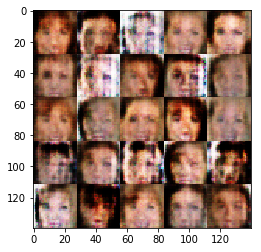

Epoch 1/1... Batch 710... Discriminator Loss: 1.3314... Generator Loss: 0.3598
Epoch 1/1... Batch 720... Discriminator Loss: 0.6978... Generator Loss: 1.8386
Epoch 1/1... Batch 730... Discriminator Loss: 1.5644... Generator Loss: 0.3524
Epoch 1/1... Batch 740... Discriminator Loss: 3.4162... Generator Loss: 2.6301
Epoch 1/1... Batch 750... Discriminator Loss: 1.5661... Generator Loss: 0.5843
Epoch 1/1... Batch 760... Discriminator Loss: 1.4215... Generator Loss: 0.7859
Epoch 1/1... Batch 770... Discriminator Loss: 1.0709... Generator Loss: 0.8880
Epoch 1/1... Batch 780... Discriminator Loss: 1.4200... Generator Loss: 0.5493
Epoch 1/1... Batch 790... Discriminator Loss: 1.1929... Generator Loss: 0.7078
Epoch 1/1... Batch 800... Discriminator Loss: 1.4175... Generator Loss: 1.0665


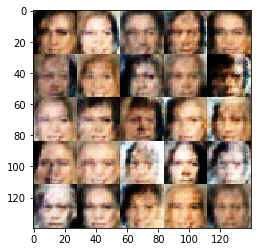

Epoch 1/1... Batch 810... Discriminator Loss: 1.2857... Generator Loss: 0.5746
Epoch 1/1... Batch 820... Discriminator Loss: 1.0175... Generator Loss: 1.0264
Epoch 1/1... Batch 830... Discriminator Loss: 1.6518... Generator Loss: 0.6837
Epoch 1/1... Batch 840... Discriminator Loss: 1.3650... Generator Loss: 0.7288
Epoch 1/1... Batch 850... Discriminator Loss: 1.3604... Generator Loss: 0.7567
Epoch 1/1... Batch 860... Discriminator Loss: 1.4258... Generator Loss: 0.4854
Epoch 1/1... Batch 870... Discriminator Loss: 1.2692... Generator Loss: 0.6266
Epoch 1/1... Batch 880... Discriminator Loss: 1.2228... Generator Loss: 0.6658
Epoch 1/1... Batch 890... Discriminator Loss: 1.4316... Generator Loss: 0.6332
Epoch 1/1... Batch 900... Discriminator Loss: 1.3512... Generator Loss: 0.6317


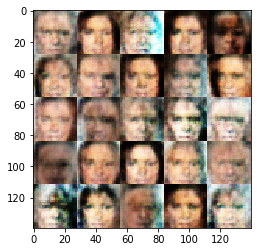

Epoch 1/1... Batch 910... Discriminator Loss: 1.4409... Generator Loss: 0.5638
Epoch 1/1... Batch 920... Discriminator Loss: 1.3326... Generator Loss: 0.7351
Epoch 1/1... Batch 930... Discriminator Loss: 1.2594... Generator Loss: 0.6717
Epoch 1/1... Batch 940... Discriminator Loss: 1.2916... Generator Loss: 0.7875
Epoch 1/1... Batch 950... Discriminator Loss: 1.4219... Generator Loss: 0.7368
Epoch 1/1... Batch 960... Discriminator Loss: 1.7079... Generator Loss: 0.5367
Epoch 1/1... Batch 970... Discriminator Loss: 1.2141... Generator Loss: 0.6289
Epoch 1/1... Batch 980... Discriminator Loss: 1.2706... Generator Loss: 0.7780
Epoch 1/1... Batch 990... Discriminator Loss: 1.4261... Generator Loss: 0.5802
Epoch 1/1... Batch 1000... Discriminator Loss: 1.0887... Generator Loss: 0.8146


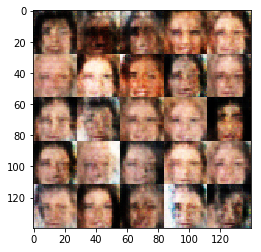

Epoch 1/1... Batch 1010... Discriminator Loss: 1.1320... Generator Loss: 1.4713
Epoch 1/1... Batch 1020... Discriminator Loss: 1.2572... Generator Loss: 0.9224
Epoch 1/1... Batch 1030... Discriminator Loss: 1.3673... Generator Loss: 0.6834
Epoch 1/1... Batch 1040... Discriminator Loss: 1.2751... Generator Loss: 0.7970
Epoch 1/1... Batch 1050... Discriminator Loss: 1.4073... Generator Loss: 0.5413
Epoch 1/1... Batch 1060... Discriminator Loss: 1.1820... Generator Loss: 0.6369
Epoch 1/1... Batch 1070... Discriminator Loss: 1.4168... Generator Loss: 0.7911
Epoch 1/1... Batch 1080... Discriminator Loss: 1.3466... Generator Loss: 0.4356
Epoch 1/1... Batch 1090... Discriminator Loss: 1.0924... Generator Loss: 0.7946
Epoch 1/1... Batch 1100... Discriminator Loss: 1.2023... Generator Loss: 0.7886


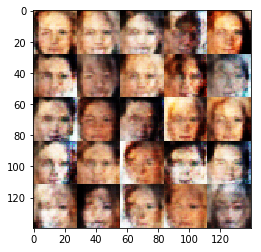

Epoch 1/1... Batch 1110... Discriminator Loss: 1.3399... Generator Loss: 0.8148
Epoch 1/1... Batch 1120... Discriminator Loss: 1.2684... Generator Loss: 0.5971
Epoch 1/1... Batch 1130... Discriminator Loss: 1.3664... Generator Loss: 0.6941
Epoch 1/1... Batch 1140... Discriminator Loss: 1.3017... Generator Loss: 1.3426
Epoch 1/1... Batch 1150... Discriminator Loss: 1.3826... Generator Loss: 0.6102
Epoch 1/1... Batch 1160... Discriminator Loss: 1.3453... Generator Loss: 0.5477
Epoch 1/1... Batch 1170... Discriminator Loss: 1.3160... Generator Loss: 0.8503
Epoch 1/1... Batch 1180... Discriminator Loss: 1.2566... Generator Loss: 0.7776
Epoch 1/1... Batch 1190... Discriminator Loss: 1.2778... Generator Loss: 0.6685
Epoch 1/1... Batch 1200... Discriminator Loss: 1.1796... Generator Loss: 0.7536


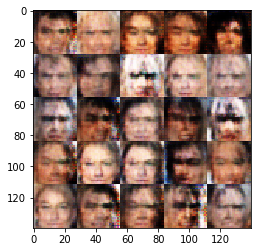

Epoch 1/1... Batch 1210... Discriminator Loss: 1.2796... Generator Loss: 0.5382
Epoch 1/1... Batch 1220... Discriminator Loss: 1.4005... Generator Loss: 0.5776
Epoch 1/1... Batch 1230... Discriminator Loss: 1.3177... Generator Loss: 0.9802
Epoch 1/1... Batch 1240... Discriminator Loss: 1.2839... Generator Loss: 0.6741
Epoch 1/1... Batch 1250... Discriminator Loss: 1.3171... Generator Loss: 0.6428
Epoch 1/1... Batch 1260... Discriminator Loss: 1.2669... Generator Loss: 0.5675
Epoch 1/1... Batch 1270... Discriminator Loss: 1.2845... Generator Loss: 0.6136
Epoch 1/1... Batch 1280... Discriminator Loss: 1.3282... Generator Loss: 1.0140
Epoch 1/1... Batch 1290... Discriminator Loss: 1.1954... Generator Loss: 0.7620
Epoch 1/1... Batch 1300... Discriminator Loss: 1.4457... Generator Loss: 0.8662


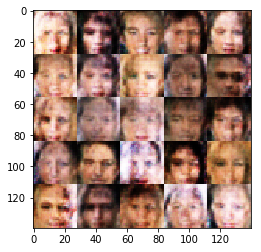

Epoch 1/1... Batch 1310... Discriminator Loss: 1.2557... Generator Loss: 0.9231
Epoch 1/1... Batch 1320... Discriminator Loss: 1.2931... Generator Loss: 0.6586
Epoch 1/1... Batch 1330... Discriminator Loss: 1.2928... Generator Loss: 0.6796
Epoch 1/1... Batch 1340... Discriminator Loss: 1.3180... Generator Loss: 0.6244
Epoch 1/1... Batch 1350... Discriminator Loss: 1.3123... Generator Loss: 0.5166
Epoch 1/1... Batch 1360... Discriminator Loss: 1.2816... Generator Loss: 0.6030
Epoch 1/1... Batch 1370... Discriminator Loss: 1.2334... Generator Loss: 0.9578
Epoch 1/1... Batch 1380... Discriminator Loss: 1.4726... Generator Loss: 0.4385
Epoch 1/1... Batch 1390... Discriminator Loss: 1.2861... Generator Loss: 0.6177
Epoch 1/1... Batch 1400... Discriminator Loss: 1.2935... Generator Loss: 0.6273


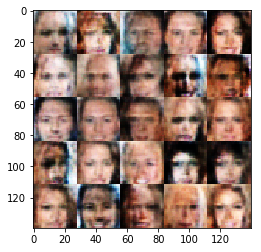

Epoch 1/1... Batch 1410... Discriminator Loss: 1.2705... Generator Loss: 0.6373
Epoch 1/1... Batch 1420... Discriminator Loss: 1.2949... Generator Loss: 0.7254
Epoch 1/1... Batch 1430... Discriminator Loss: 1.2822... Generator Loss: 0.8043
Epoch 1/1... Batch 1440... Discriminator Loss: 1.3000... Generator Loss: 0.5043
Epoch 1/1... Batch 1450... Discriminator Loss: 1.3574... Generator Loss: 0.9653
Epoch 1/1... Batch 1460... Discriminator Loss: 1.2812... Generator Loss: 0.7749
Epoch 1/1... Batch 1470... Discriminator Loss: 1.6243... Generator Loss: 0.3089
Epoch 1/1... Batch 1480... Discriminator Loss: 1.3783... Generator Loss: 0.6723
Epoch 1/1... Batch 1490... Discriminator Loss: 1.2657... Generator Loss: 0.7596
Epoch 1/1... Batch 1500... Discriminator Loss: 1.4442... Generator Loss: 1.1807


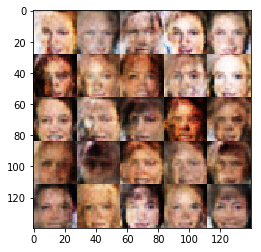

Epoch 1/1... Batch 1510... Discriminator Loss: 1.2470... Generator Loss: 0.9697
Epoch 1/1... Batch 1520... Discriminator Loss: 1.3253... Generator Loss: 0.6352
Epoch 1/1... Batch 1530... Discriminator Loss: 1.2992... Generator Loss: 0.7674
Epoch 1/1... Batch 1540... Discriminator Loss: 1.3138... Generator Loss: 1.0035
Epoch 1/1... Batch 1550... Discriminator Loss: 1.2436... Generator Loss: 0.6874
Epoch 1/1... Batch 1560... Discriminator Loss: 1.2910... Generator Loss: 0.5404
Epoch 1/1... Batch 1570... Discriminator Loss: 1.3840... Generator Loss: 0.5013
Epoch 1/1... Batch 1580... Discriminator Loss: 1.4026... Generator Loss: 0.7154
Epoch 1/1... Batch 1590... Discriminator Loss: 1.2799... Generator Loss: 0.7032
Epoch 1/1... Batch 1600... Discriminator Loss: 1.3650... Generator Loss: 0.7240


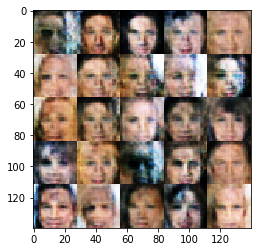

Epoch 1/1... Batch 1610... Discriminator Loss: 1.3746... Generator Loss: 1.2364
Epoch 1/1... Batch 1620... Discriminator Loss: 1.2763... Generator Loss: 0.7283
Epoch 1/1... Batch 1630... Discriminator Loss: 1.2812... Generator Loss: 0.6250
Epoch 1/1... Batch 1640... Discriminator Loss: 1.4323... Generator Loss: 0.6798
Epoch 1/1... Batch 1650... Discriminator Loss: 1.2365... Generator Loss: 0.7136
Epoch 1/1... Batch 1660... Discriminator Loss: 1.2775... Generator Loss: 0.8148
Epoch 1/1... Batch 1670... Discriminator Loss: 1.2732... Generator Loss: 0.9132
Epoch 1/1... Batch 1680... Discriminator Loss: 1.4438... Generator Loss: 0.4924
Epoch 1/1... Batch 1690... Discriminator Loss: 1.1813... Generator Loss: 0.8063
Epoch 1/1... Batch 1700... Discriminator Loss: 1.2174... Generator Loss: 0.7078


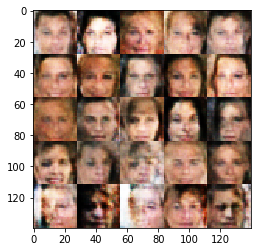

Epoch 1/1... Batch 1710... Discriminator Loss: 1.1561... Generator Loss: 0.6933
Epoch 1/1... Batch 1720... Discriminator Loss: 1.3012... Generator Loss: 0.7228
Epoch 1/1... Batch 1730... Discriminator Loss: 1.3424... Generator Loss: 0.5877
Epoch 1/1... Batch 1740... Discriminator Loss: 1.3626... Generator Loss: 0.4914
Epoch 1/1... Batch 1750... Discriminator Loss: 1.3981... Generator Loss: 0.9324
Epoch 1/1... Batch 1760... Discriminator Loss: 1.7121... Generator Loss: 0.2955
Epoch 1/1... Batch 1770... Discriminator Loss: 1.3811... Generator Loss: 0.7036
Epoch 1/1... Batch 1780... Discriminator Loss: 1.3335... Generator Loss: 0.9758
Epoch 1/1... Batch 1790... Discriminator Loss: 1.4539... Generator Loss: 0.9397
Epoch 1/1... Batch 1800... Discriminator Loss: 1.2607... Generator Loss: 0.6506


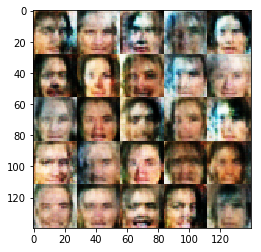

Epoch 1/1... Batch 1810... Discriminator Loss: 1.3801... Generator Loss: 0.9318
Epoch 1/1... Batch 1820... Discriminator Loss: 1.1980... Generator Loss: 0.7303
Epoch 1/1... Batch 1830... Discriminator Loss: 1.4852... Generator Loss: 0.4065
Epoch 1/1... Batch 1840... Discriminator Loss: 1.4042... Generator Loss: 0.8093
Epoch 1/1... Batch 1850... Discriminator Loss: 1.2199... Generator Loss: 0.6756
Epoch 1/1... Batch 1860... Discriminator Loss: 1.2963... Generator Loss: 0.7647
Epoch 1/1... Batch 1870... Discriminator Loss: 1.2645... Generator Loss: 0.5541
Epoch 1/1... Batch 1880... Discriminator Loss: 2.2868... Generator Loss: 2.0798
Epoch 1/1... Batch 1890... Discriminator Loss: 1.2999... Generator Loss: 0.6884
Epoch 1/1... Batch 1900... Discriminator Loss: 1.3375... Generator Loss: 0.7287


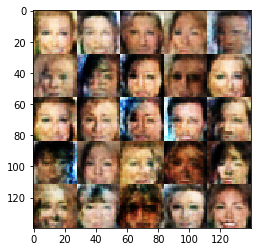

Epoch 1/1... Batch 1910... Discriminator Loss: 1.2602... Generator Loss: 0.7209
Epoch 1/1... Batch 1920... Discriminator Loss: 1.3569... Generator Loss: 0.6048
Epoch 1/1... Batch 1930... Discriminator Loss: 1.3535... Generator Loss: 0.5461
Epoch 1/1... Batch 1940... Discriminator Loss: 1.3141... Generator Loss: 1.1144
Epoch 1/1... Batch 1950... Discriminator Loss: 1.4145... Generator Loss: 0.5149
Epoch 1/1... Batch 1960... Discriminator Loss: 1.1770... Generator Loss: 0.9189
Epoch 1/1... Batch 1970... Discriminator Loss: 1.2241... Generator Loss: 0.5378
Epoch 1/1... Batch 1980... Discriminator Loss: 1.3493... Generator Loss: 0.6660
Epoch 1/1... Batch 1990... Discriminator Loss: 1.2532... Generator Loss: 0.7551
Epoch 1/1... Batch 2000... Discriminator Loss: 1.2914... Generator Loss: 0.6653


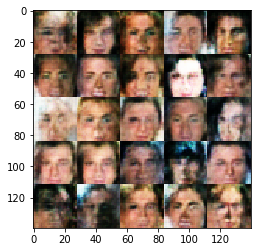

Epoch 1/1... Batch 2010... Discriminator Loss: 1.4546... Generator Loss: 0.4662
Epoch 1/1... Batch 2020... Discriminator Loss: 1.6472... Generator Loss: 1.5897
Epoch 1/1... Batch 2030... Discriminator Loss: 1.3191... Generator Loss: 0.6731
Epoch 1/1... Batch 2040... Discriminator Loss: 1.2883... Generator Loss: 0.7826
Epoch 1/1... Batch 2050... Discriminator Loss: 1.2662... Generator Loss: 0.6424
Epoch 1/1... Batch 2060... Discriminator Loss: 1.4210... Generator Loss: 1.3158
Epoch 1/1... Batch 2070... Discriminator Loss: 1.3552... Generator Loss: 0.4253
Epoch 1/1... Batch 2080... Discriminator Loss: 1.2480... Generator Loss: 0.6971
Epoch 1/1... Batch 2090... Discriminator Loss: 1.2379... Generator Loss: 0.8902
Epoch 1/1... Batch 2100... Discriminator Loss: 1.1396... Generator Loss: 0.8461


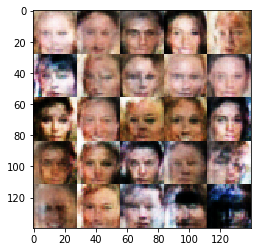

Epoch 1/1... Batch 2110... Discriminator Loss: 1.2926... Generator Loss: 1.1552
Epoch 1/1... Batch 2120... Discriminator Loss: 1.2482... Generator Loss: 0.6546
Epoch 1/1... Batch 2130... Discriminator Loss: 1.2334... Generator Loss: 0.9704
Epoch 1/1... Batch 2140... Discriminator Loss: 1.2622... Generator Loss: 0.6654
Epoch 1/1... Batch 2150... Discriminator Loss: 1.3097... Generator Loss: 0.6247
Epoch 1/1... Batch 2160... Discriminator Loss: 1.2784... Generator Loss: 0.8049
Epoch 1/1... Batch 2170... Discriminator Loss: 1.2157... Generator Loss: 0.8731
Epoch 1/1... Batch 2180... Discriminator Loss: 1.6163... Generator Loss: 0.3270
Epoch 1/1... Batch 2190... Discriminator Loss: 1.1564... Generator Loss: 0.8077
Epoch 1/1... Batch 2200... Discriminator Loss: 1.2267... Generator Loss: 0.6520


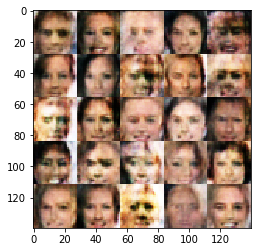

Epoch 1/1... Batch 2210... Discriminator Loss: 1.4189... Generator Loss: 0.4826
Epoch 1/1... Batch 2220... Discriminator Loss: 1.3215... Generator Loss: 0.5272
Epoch 1/1... Batch 2230... Discriminator Loss: 1.3641... Generator Loss: 0.6561
Epoch 1/1... Batch 2240... Discriminator Loss: 1.2750... Generator Loss: 0.6208
Epoch 1/1... Batch 2250... Discriminator Loss: 1.2621... Generator Loss: 0.7813
Epoch 1/1... Batch 2260... Discriminator Loss: 1.8309... Generator Loss: 1.4440
Epoch 1/1... Batch 2270... Discriminator Loss: 1.2886... Generator Loss: 0.7514
Epoch 1/1... Batch 2280... Discriminator Loss: 1.3147... Generator Loss: 0.5783
Epoch 1/1... Batch 2290... Discriminator Loss: 1.3345... Generator Loss: 0.4978
Epoch 1/1... Batch 2300... Discriminator Loss: 1.2870... Generator Loss: 0.9255


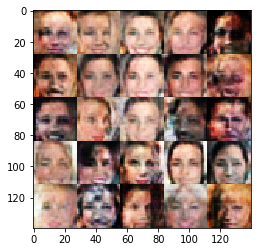

Epoch 1/1... Batch 2310... Discriminator Loss: 1.3037... Generator Loss: 0.5633
Epoch 1/1... Batch 2320... Discriminator Loss: 1.3193... Generator Loss: 0.6858
Epoch 1/1... Batch 2330... Discriminator Loss: 1.5045... Generator Loss: 0.5022
Epoch 1/1... Batch 2340... Discriminator Loss: 1.3870... Generator Loss: 0.8523
Epoch 1/1... Batch 2350... Discriminator Loss: 1.3745... Generator Loss: 0.7276
Epoch 1/1... Batch 2360... Discriminator Loss: 1.4009... Generator Loss: 0.4167
Epoch 1/1... Batch 2370... Discriminator Loss: 1.2466... Generator Loss: 0.7106
Epoch 1/1... Batch 2380... Discriminator Loss: 1.5237... Generator Loss: 0.4233
Epoch 1/1... Batch 2390... Discriminator Loss: 1.2703... Generator Loss: 0.6973
Epoch 1/1... Batch 2400... Discriminator Loss: 1.4892... Generator Loss: 0.3558


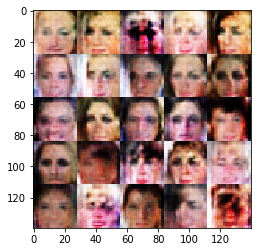

Epoch 1/1... Batch 2410... Discriminator Loss: 1.2688... Generator Loss: 0.6898
Epoch 1/1... Batch 2420... Discriminator Loss: 1.4183... Generator Loss: 0.7057
Epoch 1/1... Batch 2430... Discriminator Loss: 1.4092... Generator Loss: 0.7635
Epoch 1/1... Batch 2440... Discriminator Loss: 1.3881... Generator Loss: 0.5101
Epoch 1/1... Batch 2450... Discriminator Loss: 1.2325... Generator Loss: 0.6169
Epoch 1/1... Batch 2460... Discriminator Loss: 1.2948... Generator Loss: 0.8490
Epoch 1/1... Batch 2470... Discriminator Loss: 1.3088... Generator Loss: 0.7701
Epoch 1/1... Batch 2480... Discriminator Loss: 1.2932... Generator Loss: 0.6054
Epoch 1/1... Batch 2490... Discriminator Loss: 1.2369... Generator Loss: 0.5934
Epoch 1/1... Batch 2500... Discriminator Loss: 1.6446... Generator Loss: 1.0899


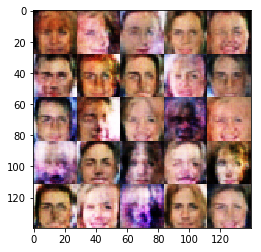

Epoch 1/1... Batch 2510... Discriminator Loss: 1.1882... Generator Loss: 0.9254
Epoch 1/1... Batch 2520... Discriminator Loss: 1.1286... Generator Loss: 1.1806
Epoch 1/1... Batch 2530... Discriminator Loss: 1.2368... Generator Loss: 0.8111
Epoch 1/1... Batch 2540... Discriminator Loss: 1.1931... Generator Loss: 0.7276
Epoch 1/1... Batch 2550... Discriminator Loss: 1.2912... Generator Loss: 0.6152
Epoch 1/1... Batch 2560... Discriminator Loss: 1.2972... Generator Loss: 0.6528
Epoch 1/1... Batch 2570... Discriminator Loss: 1.5361... Generator Loss: 0.3464
Epoch 1/1... Batch 2580... Discriminator Loss: 1.2835... Generator Loss: 0.5845
Epoch 1/1... Batch 2590... Discriminator Loss: 1.2887... Generator Loss: 0.6135
Epoch 1/1... Batch 2600... Discriminator Loss: 1.2676... Generator Loss: 0.6294


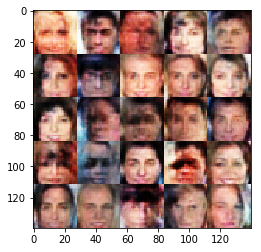

Epoch 1/1... Batch 2610... Discriminator Loss: 1.3752... Generator Loss: 0.9283
Epoch 1/1... Batch 2620... Discriminator Loss: 1.1472... Generator Loss: 0.7291
Epoch 1/1... Batch 2630... Discriminator Loss: 1.3207... Generator Loss: 0.6320
Epoch 1/1... Batch 2640... Discriminator Loss: 1.2095... Generator Loss: 0.8145
Epoch 1/1... Batch 2650... Discriminator Loss: 1.3178... Generator Loss: 0.7676
Epoch 1/1... Batch 2660... Discriminator Loss: 1.3067... Generator Loss: 0.7536
Epoch 1/1... Batch 2670... Discriminator Loss: 1.1611... Generator Loss: 0.9222
Epoch 1/1... Batch 2680... Discriminator Loss: 1.3633... Generator Loss: 0.5310
Epoch 1/1... Batch 2690... Discriminator Loss: 1.2007... Generator Loss: 0.6571
Epoch 1/1... Batch 2700... Discriminator Loss: 1.5743... Generator Loss: 0.3452


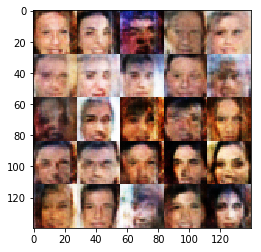

Epoch 1/1... Batch 2710... Discriminator Loss: 1.3747... Generator Loss: 0.4370
Epoch 1/1... Batch 2720... Discriminator Loss: 1.2998... Generator Loss: 0.8191
Epoch 1/1... Batch 2730... Discriminator Loss: 1.1029... Generator Loss: 0.7792
Epoch 1/1... Batch 2740... Discriminator Loss: 1.2722... Generator Loss: 0.6767
Epoch 1/1... Batch 2750... Discriminator Loss: 1.3659... Generator Loss: 0.4730
Epoch 1/1... Batch 2760... Discriminator Loss: 1.2337... Generator Loss: 0.7768
Epoch 1/1... Batch 2770... Discriminator Loss: 1.3828... Generator Loss: 0.7056
Epoch 1/1... Batch 2780... Discriminator Loss: 1.2565... Generator Loss: 0.6665
Epoch 1/1... Batch 2790... Discriminator Loss: 1.1826... Generator Loss: 0.7143
Epoch 1/1... Batch 2800... Discriminator Loss: 1.1816... Generator Loss: 0.9583


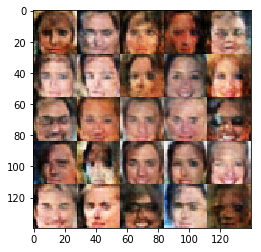

Epoch 1/1... Batch 2810... Discriminator Loss: 1.4234... Generator Loss: 0.5665
Epoch 1/1... Batch 2820... Discriminator Loss: 1.3519... Generator Loss: 0.6801
Epoch 1/1... Batch 2830... Discriminator Loss: 1.3163... Generator Loss: 0.4563
Epoch 1/1... Batch 2840... Discriminator Loss: 1.2224... Generator Loss: 0.6743
Epoch 1/1... Batch 2850... Discriminator Loss: 1.2366... Generator Loss: 0.5784
Epoch 1/1... Batch 2860... Discriminator Loss: 1.4158... Generator Loss: 0.6113
Epoch 1/1... Batch 2870... Discriminator Loss: 1.0705... Generator Loss: 0.8244
Epoch 1/1... Batch 2880... Discriminator Loss: 1.1208... Generator Loss: 0.7663
Epoch 1/1... Batch 2890... Discriminator Loss: 1.3109... Generator Loss: 0.6820
Epoch 1/1... Batch 2900... Discriminator Loss: 1.2688... Generator Loss: 0.5250


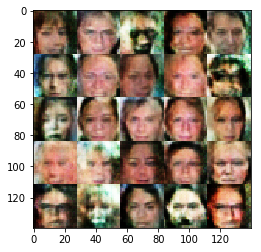

Epoch 1/1... Batch 2910... Discriminator Loss: 1.4081... Generator Loss: 0.4789
Epoch 1/1... Batch 2920... Discriminator Loss: 1.1876... Generator Loss: 1.1006
Epoch 1/1... Batch 2930... Discriminator Loss: 1.2281... Generator Loss: 0.5706
Epoch 1/1... Batch 2940... Discriminator Loss: 1.3834... Generator Loss: 0.5741
Epoch 1/1... Batch 2950... Discriminator Loss: 1.2359... Generator Loss: 0.8330
Epoch 1/1... Batch 2960... Discriminator Loss: 1.2715... Generator Loss: 0.7969
Epoch 1/1... Batch 2970... Discriminator Loss: 1.6125... Generator Loss: 0.3543
Epoch 1/1... Batch 2980... Discriminator Loss: 1.4149... Generator Loss: 0.4365
Epoch 1/1... Batch 2990... Discriminator Loss: 1.2221... Generator Loss: 0.8553
Epoch 1/1... Batch 3000... Discriminator Loss: 1.4062... Generator Loss: 1.1917


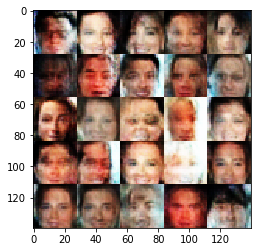

Epoch 1/1... Batch 3010... Discriminator Loss: 1.2715... Generator Loss: 0.7719
Epoch 1/1... Batch 3020... Discriminator Loss: 1.2355... Generator Loss: 1.2448
Epoch 1/1... Batch 3030... Discriminator Loss: 1.3367... Generator Loss: 0.4085
Epoch 1/1... Batch 3040... Discriminator Loss: 1.2906... Generator Loss: 0.7411
Epoch 1/1... Batch 3050... Discriminator Loss: 1.4167... Generator Loss: 1.0596
Epoch 1/1... Batch 3060... Discriminator Loss: 1.1511... Generator Loss: 0.9601
Epoch 1/1... Batch 3070... Discriminator Loss: 1.6347... Generator Loss: 1.4374
Epoch 1/1... Batch 3080... Discriminator Loss: 1.5579... Generator Loss: 0.3381
Epoch 1/1... Batch 3090... Discriminator Loss: 1.1621... Generator Loss: 0.8151
Epoch 1/1... Batch 3100... Discriminator Loss: 1.2391... Generator Loss: 0.5714


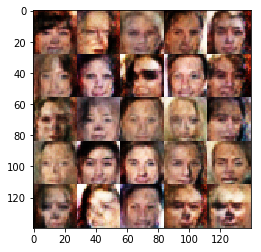

Epoch 1/1... Batch 3110... Discriminator Loss: 1.4653... Generator Loss: 0.4378
Epoch 1/1... Batch 3120... Discriminator Loss: 1.3815... Generator Loss: 0.5741
Epoch 1/1... Batch 3130... Discriminator Loss: 1.3138... Generator Loss: 0.6662
Epoch 1/1... Batch 3140... Discriminator Loss: 1.2435... Generator Loss: 0.7266
Epoch 1/1... Batch 3150... Discriminator Loss: 1.3952... Generator Loss: 0.6520
Epoch 1/1... Batch 3160... Discriminator Loss: 1.2491... Generator Loss: 0.7401
Epoch 1/1... Batch 3170... Discriminator Loss: 1.4058... Generator Loss: 0.6844
Epoch 1/1... Batch 3180... Discriminator Loss: 1.3439... Generator Loss: 0.5411
Epoch 1/1... Batch 3190... Discriminator Loss: 1.3498... Generator Loss: 0.6216
Epoch 1/1... Batch 3200... Discriminator Loss: 1.7303... Generator Loss: 1.5094


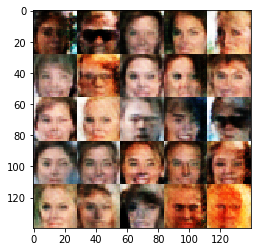

Epoch 1/1... Batch 3210... Discriminator Loss: 1.3776... Generator Loss: 0.4921
Epoch 1/1... Batch 3220... Discriminator Loss: 1.3515... Generator Loss: 0.4189
Epoch 1/1... Batch 3230... Discriminator Loss: 1.5283... Generator Loss: 0.4484
Epoch 1/1... Batch 3240... Discriminator Loss: 1.1311... Generator Loss: 0.7702
Epoch 1/1... Batch 3250... Discriminator Loss: 1.8421... Generator Loss: 1.5698
Epoch 1/1... Batch 3260... Discriminator Loss: 1.2635... Generator Loss: 0.6884
Epoch 1/1... Batch 3270... Discriminator Loss: 1.4983... Generator Loss: 0.4293
Epoch 1/1... Batch 3280... Discriminator Loss: 1.3108... Generator Loss: 0.7714
Epoch 1/1... Batch 3290... Discriminator Loss: 1.6535... Generator Loss: 0.3108
Epoch 1/1... Batch 3300... Discriminator Loss: 1.3059... Generator Loss: 0.5513


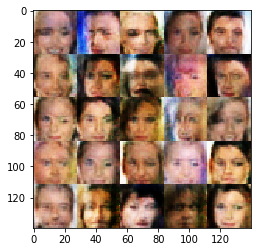

Epoch 1/1... Batch 3310... Discriminator Loss: 1.3221... Generator Loss: 1.0552
Epoch 1/1... Batch 3320... Discriminator Loss: 1.3274... Generator Loss: 0.7666
Epoch 1/1... Batch 3330... Discriminator Loss: 1.4616... Generator Loss: 0.4525
Epoch 1/1... Batch 3340... Discriminator Loss: 1.3587... Generator Loss: 0.4889
Epoch 1/1... Batch 3350... Discriminator Loss: 1.2331... Generator Loss: 0.7169
Epoch 1/1... Batch 3360... Discriminator Loss: 1.0447... Generator Loss: 0.8113
Epoch 1/1... Batch 3370... Discriminator Loss: 1.4769... Generator Loss: 0.3682
Epoch 1/1... Batch 3380... Discriminator Loss: 1.2343... Generator Loss: 0.7678
Epoch 1/1... Batch 3390... Discriminator Loss: 1.2866... Generator Loss: 0.8376
Epoch 1/1... Batch 3400... Discriminator Loss: 1.2040... Generator Loss: 0.5666


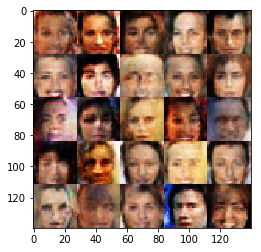

Epoch 1/1... Batch 3410... Discriminator Loss: 1.5348... Generator Loss: 1.1491
Epoch 1/1... Batch 3420... Discriminator Loss: 1.2972... Generator Loss: 0.8101
Epoch 1/1... Batch 3430... Discriminator Loss: 1.1493... Generator Loss: 0.6550
Epoch 1/1... Batch 3440... Discriminator Loss: 1.4854... Generator Loss: 0.3516
Epoch 1/1... Batch 3450... Discriminator Loss: 1.2816... Generator Loss: 1.2567
Epoch 1/1... Batch 3460... Discriminator Loss: 1.3015... Generator Loss: 0.6215
Epoch 1/1... Batch 3470... Discriminator Loss: 1.5537... Generator Loss: 0.2977
Epoch 1/1... Batch 3480... Discriminator Loss: 1.2946... Generator Loss: 0.8048
Epoch 1/1... Batch 3490... Discriminator Loss: 1.5425... Generator Loss: 0.3830
Epoch 1/1... Batch 3500... Discriminator Loss: 1.1778... Generator Loss: 1.3389


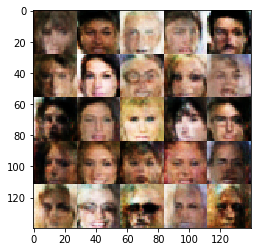

Epoch 1/1... Batch 3510... Discriminator Loss: 1.3526... Generator Loss: 0.5745
Epoch 1/1... Batch 3520... Discriminator Loss: 1.4701... Generator Loss: 0.5605
Epoch 1/1... Batch 3530... Discriminator Loss: 1.4724... Generator Loss: 0.4935
Epoch 1/1... Batch 3540... Discriminator Loss: 1.4064... Generator Loss: 1.5207
Epoch 1/1... Batch 3550... Discriminator Loss: 1.4416... Generator Loss: 0.7862
Epoch 1/1... Batch 3560... Discriminator Loss: 1.2449... Generator Loss: 0.6459
Epoch 1/1... Batch 3570... Discriminator Loss: 1.4037... Generator Loss: 0.8664
Epoch 1/1... Batch 3580... Discriminator Loss: 1.2758... Generator Loss: 0.5813
Epoch 1/1... Batch 3590... Discriminator Loss: 1.3692... Generator Loss: 0.6031
Epoch 1/1... Batch 3600... Discriminator Loss: 1.8437... Generator Loss: 0.2392


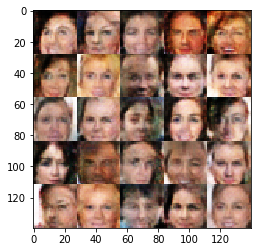

Epoch 1/1... Batch 3610... Discriminator Loss: 1.0358... Generator Loss: 1.0649
Epoch 1/1... Batch 3620... Discriminator Loss: 1.2454... Generator Loss: 0.9070
Epoch 1/1... Batch 3630... Discriminator Loss: 1.2852... Generator Loss: 0.6238
Epoch 1/1... Batch 3640... Discriminator Loss: 1.3395... Generator Loss: 0.7592
Epoch 1/1... Batch 3650... Discriminator Loss: 1.3071... Generator Loss: 0.7018
Epoch 1/1... Batch 3660... Discriminator Loss: 1.3255... Generator Loss: 0.5111
Epoch 1/1... Batch 3670... Discriminator Loss: 1.1950... Generator Loss: 0.5885
Epoch 1/1... Batch 3680... Discriminator Loss: 1.2585... Generator Loss: 0.5370
Epoch 1/1... Batch 3690... Discriminator Loss: 1.2342... Generator Loss: 0.7468
Epoch 1/1... Batch 3700... Discriminator Loss: 1.2435... Generator Loss: 0.7662


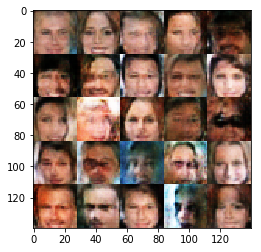

Epoch 1/1... Batch 3710... Discriminator Loss: 1.4147... Generator Loss: 0.4693
Epoch 1/1... Batch 3720... Discriminator Loss: 1.2472... Generator Loss: 0.8201
Epoch 1/1... Batch 3730... Discriminator Loss: 1.3689... Generator Loss: 0.5342
Epoch 1/1... Batch 3740... Discriminator Loss: 1.2736... Generator Loss: 0.6469
Epoch 1/1... Batch 3750... Discriminator Loss: 1.2469... Generator Loss: 0.6027
Epoch 1/1... Batch 3760... Discriminator Loss: 1.2612... Generator Loss: 0.5092
Epoch 1/1... Batch 3770... Discriminator Loss: 1.3594... Generator Loss: 0.5960
Epoch 1/1... Batch 3780... Discriminator Loss: 1.3102... Generator Loss: 0.9223
Epoch 1/1... Batch 3790... Discriminator Loss: 1.2077... Generator Loss: 0.6195
Epoch 1/1... Batch 3800... Discriminator Loss: 2.0433... Generator Loss: 0.1602


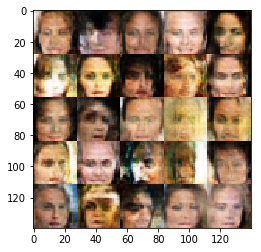

Epoch 1/1... Batch 3810... Discriminator Loss: 1.4135... Generator Loss: 0.4519
Epoch 1/1... Batch 3820... Discriminator Loss: 1.2904... Generator Loss: 0.7055
Epoch 1/1... Batch 3830... Discriminator Loss: 1.2810... Generator Loss: 0.4926
Epoch 1/1... Batch 3840... Discriminator Loss: 1.4294... Generator Loss: 0.4811
Epoch 1/1... Batch 3850... Discriminator Loss: 1.3857... Generator Loss: 0.6050
Epoch 1/1... Batch 3860... Discriminator Loss: 1.4353... Generator Loss: 0.5902
Epoch 1/1... Batch 3870... Discriminator Loss: 1.4069... Generator Loss: 0.4456
Epoch 1/1... Batch 3880... Discriminator Loss: 1.2585... Generator Loss: 0.7842
Epoch 1/1... Batch 3890... Discriminator Loss: 1.3432... Generator Loss: 0.7366
Epoch 1/1... Batch 3900... Discriminator Loss: 1.3702... Generator Loss: 0.4406


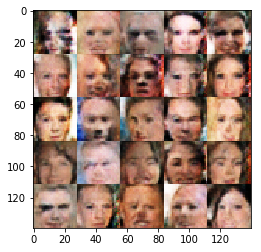

Epoch 1/1... Batch 3910... Discriminator Loss: 1.2459... Generator Loss: 0.9983
Epoch 1/1... Batch 3920... Discriminator Loss: 1.2583... Generator Loss: 0.7431
Epoch 1/1... Batch 3930... Discriminator Loss: 1.1927... Generator Loss: 0.7399
Epoch 1/1... Batch 3940... Discriminator Loss: 1.4292... Generator Loss: 0.5599
Epoch 1/1... Batch 3950... Discriminator Loss: 1.2755... Generator Loss: 0.4889
Epoch 1/1... Batch 3960... Discriminator Loss: 1.3310... Generator Loss: 0.5192
Epoch 1/1... Batch 3970... Discriminator Loss: 1.4313... Generator Loss: 0.4350
Epoch 1/1... Batch 3980... Discriminator Loss: 1.2528... Generator Loss: 0.5791
Epoch 1/1... Batch 3990... Discriminator Loss: 1.2464... Generator Loss: 0.6973
Epoch 1/1... Batch 4000... Discriminator Loss: 1.2149... Generator Loss: 0.7091


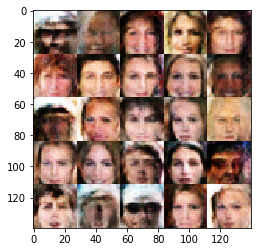

Epoch 1/1... Batch 4010... Discriminator Loss: 1.4016... Generator Loss: 0.9160
Epoch 1/1... Batch 4020... Discriminator Loss: 1.2652... Generator Loss: 0.6194
Epoch 1/1... Batch 4030... Discriminator Loss: 1.3029... Generator Loss: 0.6185
Epoch 1/1... Batch 4040... Discriminator Loss: 1.2391... Generator Loss: 0.9400
Epoch 1/1... Batch 4050... Discriminator Loss: 1.7177... Generator Loss: 0.2668
Epoch 1/1... Batch 4060... Discriminator Loss: 1.2811... Generator Loss: 0.5978
Epoch 1/1... Batch 4070... Discriminator Loss: 1.3301... Generator Loss: 0.5404
Epoch 1/1... Batch 4080... Discriminator Loss: 1.3397... Generator Loss: 0.5091
Epoch 1/1... Batch 4090... Discriminator Loss: 1.2210... Generator Loss: 0.7135
Epoch 1/1... Batch 4100... Discriminator Loss: 1.6887... Generator Loss: 0.2651


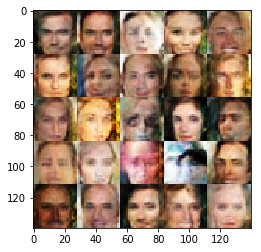

Epoch 1/1... Batch 4110... Discriminator Loss: 1.3386... Generator Loss: 0.7302
Epoch 1/1... Batch 4120... Discriminator Loss: 1.2020... Generator Loss: 0.6680
Epoch 1/1... Batch 4130... Discriminator Loss: 1.4951... Generator Loss: 0.3731
Epoch 1/1... Batch 4140... Discriminator Loss: 1.4584... Generator Loss: 0.4414
Epoch 1/1... Batch 4150... Discriminator Loss: 1.5541... Generator Loss: 0.3292
Epoch 1/1... Batch 4160... Discriminator Loss: 1.2491... Generator Loss: 0.6437
Epoch 1/1... Batch 4170... Discriminator Loss: 1.4085... Generator Loss: 0.6685
Epoch 1/1... Batch 4180... Discriminator Loss: 1.3206... Generator Loss: 0.4714
Epoch 1/1... Batch 4190... Discriminator Loss: 1.3730... Generator Loss: 0.5895
Epoch 1/1... Batch 4200... Discriminator Loss: 1.1933... Generator Loss: 0.7846


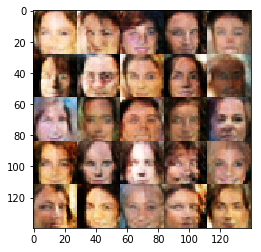

Epoch 1/1... Batch 4210... Discriminator Loss: 1.2410... Generator Loss: 0.5644
Epoch 1/1... Batch 4220... Discriminator Loss: 1.3810... Generator Loss: 0.4847
Epoch 1/1... Batch 4230... Discriminator Loss: 1.3174... Generator Loss: 0.5357
Epoch 1/1... Batch 4240... Discriminator Loss: 1.3316... Generator Loss: 0.7634
Epoch 1/1... Batch 4250... Discriminator Loss: 1.2097... Generator Loss: 0.4634
Epoch 1/1... Batch 4260... Discriminator Loss: 1.1963... Generator Loss: 1.0974
Epoch 1/1... Batch 4270... Discriminator Loss: 1.3497... Generator Loss: 0.5553
Epoch 1/1... Batch 4280... Discriminator Loss: 1.2669... Generator Loss: 0.6795
Epoch 1/1... Batch 4290... Discriminator Loss: 1.3315... Generator Loss: 0.5925
Epoch 1/1... Batch 4300... Discriminator Loss: 1.2861... Generator Loss: 0.8170


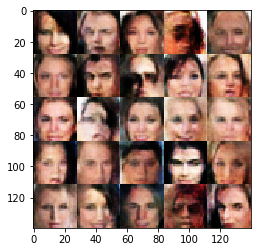

Epoch 1/1... Batch 4310... Discriminator Loss: 1.3304... Generator Loss: 0.6775
Epoch 1/1... Batch 4320... Discriminator Loss: 0.9903... Generator Loss: 1.0048
Epoch 1/1... Batch 4330... Discriminator Loss: 0.9791... Generator Loss: 1.0378
Epoch 1/1... Batch 4340... Discriminator Loss: 1.2891... Generator Loss: 0.7784
Epoch 1/1... Batch 4350... Discriminator Loss: 1.2761... Generator Loss: 0.5488
Epoch 1/1... Batch 4360... Discriminator Loss: 1.2653... Generator Loss: 0.6657
Epoch 1/1... Batch 4370... Discriminator Loss: 1.4119... Generator Loss: 0.4916
Epoch 1/1... Batch 4380... Discriminator Loss: 1.4932... Generator Loss: 0.3408
Epoch 1/1... Batch 4390... Discriminator Loss: 1.2502... Generator Loss: 0.9048
Epoch 1/1... Batch 4400... Discriminator Loss: 1.3358... Generator Loss: 0.5246


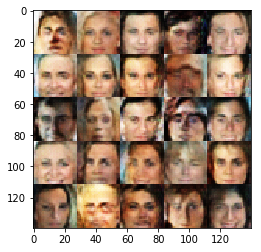

Epoch 1/1... Batch 4410... Discriminator Loss: 1.2333... Generator Loss: 0.5911
Epoch 1/1... Batch 4420... Discriminator Loss: 1.4992... Generator Loss: 0.3957
Epoch 1/1... Batch 4430... Discriminator Loss: 1.1027... Generator Loss: 0.7108
Epoch 1/1... Batch 4440... Discriminator Loss: 1.0594... Generator Loss: 0.9014
Epoch 1/1... Batch 4450... Discriminator Loss: 1.3694... Generator Loss: 0.4522
Epoch 1/1... Batch 4460... Discriminator Loss: 1.1294... Generator Loss: 0.6217
Epoch 1/1... Batch 4470... Discriminator Loss: 1.2301... Generator Loss: 0.8449
Epoch 1/1... Batch 4480... Discriminator Loss: 1.5772... Generator Loss: 0.3350
Epoch 1/1... Batch 4490... Discriminator Loss: 1.2976... Generator Loss: 0.5391
Epoch 1/1... Batch 4500... Discriminator Loss: 1.3358... Generator Loss: 0.4532


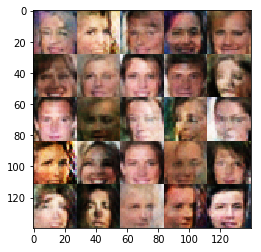

Epoch 1/1... Batch 4510... Discriminator Loss: 1.2619... Generator Loss: 0.6441
Epoch 1/1... Batch 4520... Discriminator Loss: 1.2855... Generator Loss: 0.5795
Epoch 1/1... Batch 4530... Discriminator Loss: 1.2090... Generator Loss: 0.8391
Epoch 1/1... Batch 4540... Discriminator Loss: 1.4972... Generator Loss: 1.2428
Epoch 1/1... Batch 4550... Discriminator Loss: 1.2445... Generator Loss: 0.5828
Epoch 1/1... Batch 4560... Discriminator Loss: 1.4025... Generator Loss: 0.4517
Epoch 1/1... Batch 4570... Discriminator Loss: 1.4577... Generator Loss: 0.4554
Epoch 1/1... Batch 4580... Discriminator Loss: 1.2751... Generator Loss: 0.8885
Epoch 1/1... Batch 4590... Discriminator Loss: 1.3879... Generator Loss: 0.5392
Epoch 1/1... Batch 4600... Discriminator Loss: 1.1146... Generator Loss: 0.7596


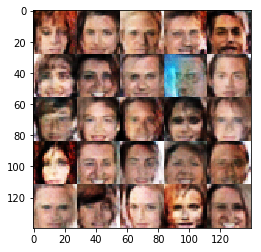

Epoch 1/1... Batch 4610... Discriminator Loss: 1.3578... Generator Loss: 0.3822
Epoch 1/1... Batch 4620... Discriminator Loss: 1.3874... Generator Loss: 0.4688
Epoch 1/1... Batch 4630... Discriminator Loss: 1.1335... Generator Loss: 1.1402
Epoch 1/1... Batch 4640... Discriminator Loss: 1.1939... Generator Loss: 0.7195
Epoch 1/1... Batch 4650... Discriminator Loss: 1.5345... Generator Loss: 0.3958
Epoch 1/1... Batch 4660... Discriminator Loss: 1.2515... Generator Loss: 0.6882
Epoch 1/1... Batch 4670... Discriminator Loss: 1.3678... Generator Loss: 0.7644
Epoch 1/1... Batch 4680... Discriminator Loss: 1.4161... Generator Loss: 0.5935
Epoch 1/1... Batch 4690... Discriminator Loss: 1.1979... Generator Loss: 0.8692


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.